# Autoencoders

In [5]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import seaborn as sns
# import umap
from sklearn.manifold import TSNE

### Importation des données

In [6]:
data = pd.read_csv("/Users/user/Documents/Cours/CentraleSupelec/Deep Learning in Finance/TD3/us_equities_logreturns_cut.csv", usecols = [x for x in range(1, 300)])
data.dropna(axis=1, inplace=True)
print(data)

         ^GSPC        GE       IBM       DIS        BA       CAT        AA  \
0    -0.007032 -0.014556  0.010490 -0.026062 -0.022809  0.003367 -0.014736   
1     0.012328  0.018882 -0.002737  0.018079  0.023845  0.007257 -0.018387   
2    -0.004491  0.002156 -0.015313  0.000943 -0.028630 -0.009500  0.019061   
3     0.027738  0.032489  0.034315  0.023739  0.015598  0.040170  0.027927   
4    -0.002796  0.016541  0.000000 -0.002303  0.018969 -0.007037 -0.015197   
...        ...       ...       ...       ...       ...       ...       ...   
4150  0.000305 -0.005420 -0.002896  0.004063 -0.009916 -0.000207 -0.001642   
4151 -0.011770 -0.016439 -0.012537 -0.017978 -0.020624 -0.012576 -0.025803   
4152 -0.002826 -0.009118 -0.009232  0.001750  0.009959 -0.002304 -0.001688   
4153  0.009568  0.012663  0.019565  0.016351  0.018590  0.002931  0.005055   
4154  0.007194  0.008614  0.005367  0.007345 -0.011064  0.007705  0.008368   

            DD       XOM        PG  ...       TER       BHP    

# 1 Catégorisation d'actifs
## 1.1 Rendements bruts

In [7]:
def build_AE(N, B, loss, activation, L1_eps=0):
    inputs = Input(shape=(N,))
    encoder = Dense(N,activation=activation)(inputs)

    bottleneck = Dense(B, activation=activation, bias_regularizer=keras.regularizers.L1(l1=L1_eps))(encoder)

    decoder = Dense(N,activation="linear")(bottleneck)

    model = Model(inputs=inputs, outputs=decoder)
    model.compile(loss=loss, optimizer='adam')

    return inputs, encoder, bottleneck, decoder, model

In [8]:
train_fraction = 0.8
val_fraction = 0.1
test_fraction = 0.1

total_samples = len(data)
train_end = int(train_fraction * total_samples)
val_end = train_end + int(val_fraction * total_samples)

X_train = data.iloc[:train_end]
X_val = data.iloc[train_end:val_end]
X_test = data.iloc[val_end:]

In [9]:
N = len(data.columns)
B = 30
loss = 'mse'
activation = 'sigmoid'

inputs, encoder, bottleneck, decoder, model = build_AE(N, B, loss, activation, L1_eps=0.01)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, X_train, epochs=500, batch_size=64, validation_split=0.1, shuffle=False, callbacks=[early_stopping])

Epoch 1/500
47/47 [==============================] - 0s 4ms/step - loss: 0.0176 - val_loss: 8.0085e-04
Epoch 2/500
47/47 [==============================] - 0s 1ms/step - loss: 6.9544e-04 - val_loss: 4.0739e-04
Epoch 3/500
47/47 [==============================] - 0s 2ms/step - loss: 5.9894e-04 - val_loss: 3.8773e-04
Epoch 4/500
47/47 [==============================] - 0s 1ms/step - loss: 5.8720e-04 - val_loss: 3.8425e-04
Epoch 5/500
47/47 [==============================] - 0s 2ms/step - loss: 5.7775e-04 - val_loss: 3.7619e-04
Epoch 6/500
47/47 [==============================] - 0s 2ms/step - loss: 5.6782e-04 - val_loss: 3.6468e-04
Epoch 7/500
47/47 [==============================] - 0s 2ms/step - loss: 5.5843e-04 - val_loss: 3.6057e-04
Epoch 8/500
47/47 [==============================] - 0s 3ms/step - loss: 5.4795e-04 - val_loss: 3.5192e-04
Epoch 9/500
47/47 [==============================] - 0s 3ms/step - loss: 5.3835e-04 - val_loss: 3.4990e-04
Epoch 10/500
47/47 [=====================

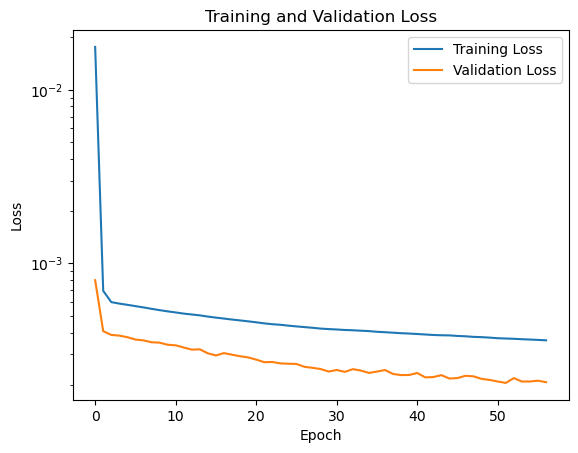

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.show()

In [11]:
def compute_frac(ri_original, ri_reconstructed):
    vals = np.where(np.sign(ri_original) == np.sign(ri_reconstructed), 1, 0)
    return np.sum(vals)/(np.shape(ri_original)[0] * np.shape(ri_original)[1])

In [12]:
ri_train_reconstructed = model.predict(X_train)
ri_val_reconstructed = model.predict(X_val)
ri_test_reconstructed = model.predict(X_test)

accuracy_train = compute_frac(X_train.values, ri_train_reconstructed)
accuracy_val = compute_frac(X_val.values, ri_val_reconstructed)
accuracy_test = compute_frac(X_test.values, ri_test_reconstructed)

print("Fraction moyenne de signaux apprise correctement (entraînement) :", accuracy_train)
print("Fraction moyenne de signaux apprise correctement (validation) :", accuracy_val)
print("Fraction moyenne de signaux apprise correctement (test) :", accuracy_test)

13/13 [==============================] - 0s 1ms/step
Fraction moyenne de signaux apprise correctement (entraînement) : 0.7003860810268753
Fraction moyenne de signaux apprise correctement (validation) : 0.7555722891566266
Fraction moyenne de signaux apprise correctement (test) : 0.7207281650641025


In [13]:
B_values = np.linspace(1, 99, 10)
accuray_test_values = np.zeros(len(B_values))
for i, B_value in enumerate(B_values):
  inputs, encoder, bottleneck, decoder, model = build_AE(N, B_value, loss, activation, L1_eps=0.01)
  model.fit(X_train, X_train, epochs=500, batch_size=64, validation_split=0.1, shuffle=False, callbacks=[early_stopping])
  ri_test_reconstructed = model.predict(X_test)
  accuray_test_values[i] = compute_frac(X_test, ri_test_reconstructed)

Epoch 1/500
47/47 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 4.4034e-04
Epoch 2/500
47/47 [==============================] - 0s 2ms/step - loss: 6.1128e-04 - val_loss: 3.9131e-04
Epoch 3/500
47/47 [==============================] - 0s 1ms/step - loss: 5.9755e-04 - val_loss: 3.9000e-04
Epoch 4/500
47/47 [==============================] - 0s 2ms/step - loss: 5.9569e-04 - val_loss: 3.8566e-04
Epoch 5/500
47/47 [==============================] - 0s 2ms/step - loss: 5.9391e-04 - val_loss: 3.8629e-04
Epoch 6/500
47/47 [==============================] - 0s 2ms/step - loss: 5.9207e-04 - val_loss: 3.8390e-04
Epoch 7/500
47/47 [==============================] - 0s 1ms/step - loss: 5.8971e-04 - val_loss: 3.8091e-04
Epoch 8/500
47/47 [==============================] - 0s 2ms/step - loss: 5.8691e-04 - val_loss: 3.7893e-04
Epoch 9/500
47/47 [==============================] - 0s 886us/step - loss: 5.8335e-04 - val_loss: 3.7338e-04
Epoch 10/500
47/47 [===================

Epoch 77/500
47/47 [==============================] - 0s 1ms/step - loss: 4.2003e-04 - val_loss: 2.2418e-04
Epoch 78/500
47/47 [==============================] - 0s 1ms/step - loss: 4.2001e-04 - val_loss: 2.2209e-04
Epoch 79/500
47/47 [==============================] - 0s 826us/step - loss: 4.1984e-04 - val_loss: 2.2142e-04
Epoch 80/500
47/47 [==============================] - 0s 2ms/step - loss: 4.1995e-04 - val_loss: 2.2406e-04
Epoch 81/500
47/47 [==============================] - 0s 1ms/step - loss: 4.1986e-04 - val_loss: 2.2147e-04
Epoch 82/500
47/47 [==============================] - 0s 904us/step - loss: 4.1974e-04 - val_loss: 2.2303e-04
Epoch 83/500
47/47 [==============================] - 0s 1ms/step - loss: 4.1992e-04 - val_loss: 2.2299e-04
Epoch 84/500
47/47 [==============================] - 0s 995us/step - loss: 4.1972e-04 - val_loss: 2.2140e-04
Epoch 85/500
47/47 [==============================] - 0s 2ms/step - loss: 4.1968e-04 - val_loss: 2.2361e-04
Epoch 86/500
47/47 [==

Epoch 6/500
47/47 [==============================] - 0s 1ms/step - loss: 5.9660e-04 - val_loss: 3.9238e-04
Epoch 7/500
47/47 [==============================] - 0s 2ms/step - loss: 5.9140e-04 - val_loss: 3.8355e-04
Epoch 8/500
47/47 [==============================] - 0s 2ms/step - loss: 5.8557e-04 - val_loss: 3.7888e-04
Epoch 9/500
47/47 [==============================] - 0s 2ms/step - loss: 5.8102e-04 - val_loss: 3.7606e-04
Epoch 10/500
47/47 [==============================] - 0s 1ms/step - loss: 5.7657e-04 - val_loss: 3.6811e-04
Epoch 11/500
47/47 [==============================] - 0s 2ms/step - loss: 5.6806e-04 - val_loss: 3.6581e-04
Epoch 12/500
47/47 [==============================] - 0s 2ms/step - loss: 5.6040e-04 - val_loss: 3.5938e-04
Epoch 13/500
47/47 [==============================] - 0s 931us/step - loss: 5.5309e-04 - val_loss: 3.4754e-04
Epoch 14/500
47/47 [==============================] - 0s 2ms/step - loss: 5.4413e-04 - val_loss: 3.4429e-04
Epoch 15/500
47/47 [==========

47/47 [==============================] - 0s 1ms/step - loss: 4.4122e-04 - val_loss: 2.6527e-04
Epoch 26/500
47/47 [==============================] - 0s 1ms/step - loss: 4.3748e-04 - val_loss: 2.5762e-04
Epoch 27/500
47/47 [==============================] - 0s 2ms/step - loss: 4.3269e-04 - val_loss: 2.5491e-04
Epoch 28/500
47/47 [==============================] - 0s 2ms/step - loss: 4.2949e-04 - val_loss: 2.5134e-04
Epoch 29/500
47/47 [==============================] - 0s 2ms/step - loss: 4.2568e-04 - val_loss: 2.3719e-04
Epoch 30/500
47/47 [==============================] - 0s 2ms/step - loss: 4.2159e-04 - val_loss: 2.4509e-04
Epoch 31/500
47/47 [==============================] - 0s 2ms/step - loss: 4.1699e-04 - val_loss: 2.4362e-04
Epoch 32/500
47/47 [==============================] - 0s 2ms/step - loss: 4.1353e-04 - val_loss: 2.3891e-04
Epoch 33/500
47/47 [==============================] - 0s 2ms/step - loss: 4.1028e-04 - val_loss: 2.3858e-04
Epoch 34/500
13/13 [=====================

47/47 [==============================] - 0s 2ms/step - loss: 4.7051e-04 - val_loss: 2.9694e-04
Epoch 24/500
47/47 [==============================] - 0s 1ms/step - loss: 4.6283e-04 - val_loss: 2.8082e-04
Epoch 25/500
47/47 [==============================] - 0s 2ms/step - loss: 4.5875e-04 - val_loss: 2.7124e-04
Epoch 26/500
47/47 [==============================] - 0s 2ms/step - loss: 4.5190e-04 - val_loss: 2.6925e-04
Epoch 27/500
47/47 [==============================] - 0s 1ms/step - loss: 4.4840e-04 - val_loss: 2.7143e-04
Epoch 28/500
47/47 [==============================] - 0s 1ms/step - loss: 4.4524e-04 - val_loss: 2.7054e-04
Epoch 29/500
47/47 [==============================] - 0s 2ms/step - loss: 4.3926e-04 - val_loss: 2.6670e-04
Epoch 30/500
47/47 [==============================] - 0s 1ms/step - loss: 4.3510e-04 - val_loss: 2.6600e-04
Epoch 31/500
47/47 [==============================] - 0s 2ms/step - loss: 4.3202e-04 - val_loss: 2.5573e-04
Epoch 32/500
47/47 [=====================

47/47 [==============================] - 0s 1ms/step - loss: 4.5719e-04 - val_loss: 2.9073e-04
Epoch 26/500
47/47 [==============================] - 0s 2ms/step - loss: 4.5439e-04 - val_loss: 2.8445e-04
Epoch 27/500
47/47 [==============================] - 0s 2ms/step - loss: 4.4935e-04 - val_loss: 2.8786e-04
Epoch 28/500
47/47 [==============================] - 0s 1ms/step - loss: 4.4522e-04 - val_loss: 2.7573e-04
Epoch 29/500
47/47 [==============================] - 0s 1ms/step - loss: 4.4363e-04 - val_loss: 2.8201e-04
Epoch 30/500
47/47 [==============================] - 0s 2ms/step - loss: 4.3776e-04 - val_loss: 2.8042e-04
Epoch 31/500
47/47 [==============================] - 0s 1ms/step - loss: 4.3724e-04 - val_loss: 2.7551e-04
Epoch 32/500
47/47 [==============================] - 0s 2ms/step - loss: 4.3080e-04 - val_loss: 2.8174e-04
Epoch 33/500
47/47 [==============================] - 0s 2ms/step - loss: 4.3035e-04 - val_loss: 2.7784e-04
Epoch 34/500
47/47 [=====================

47/47 [==============================] - 0s 1ms/step - loss: 5.7277e-04 - val_loss: 3.9696e-04
Epoch 13/500
47/47 [==============================] - 0s 2ms/step - loss: 5.6332e-04 - val_loss: 3.7754e-04
Epoch 14/500
47/47 [==============================] - 0s 2ms/step - loss: 5.5499e-04 - val_loss: 3.6341e-04
Epoch 15/500
47/47 [==============================] - 0s 2ms/step - loss: 5.4467e-04 - val_loss: 3.6881e-04
Epoch 16/500
47/47 [==============================] - 0s 1ms/step - loss: 5.3542e-04 - val_loss: 3.6668e-04
Epoch 17/500
47/47 [==============================] - 0s 2ms/step - loss: 5.2851e-04 - val_loss: 3.4275e-04
Epoch 18/500
47/47 [==============================] - 0s 2ms/step - loss: 5.1929e-04 - val_loss: 3.5230e-04
Epoch 19/500
47/47 [==============================] - 0s 2ms/step - loss: 5.1150e-04 - val_loss: 3.3311e-04
Epoch 20/500
47/47 [==============================] - 0s 1ms/step - loss: 5.0585e-04 - val_loss: 3.2345e-04
Epoch 21/500
47/47 [=====================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


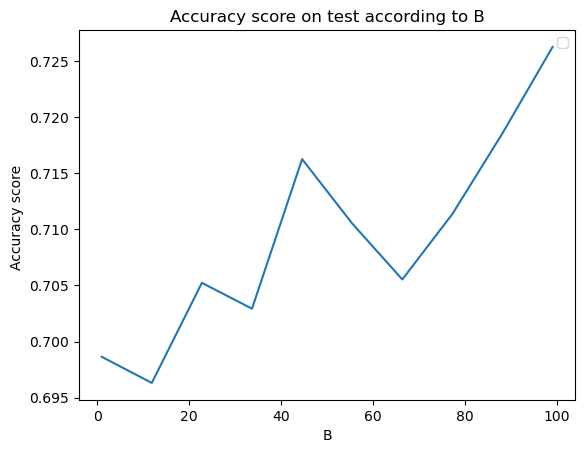

In [14]:
plt.plot(B_values, accuray_test_values)
plt.title("Accuracy score on test according to B")
plt.xlabel("B")
plt.ylabel("Accuracy score ")
plt.legend()

In [15]:
N = len(data.columns)
B = B_values[np.argmax(accuray_test_values)]
loss = 'mse'
activation = 'sigmoid'

inputs, encoder, bottleneck, decoder, model = build_AE(N, B, loss, activation, L1_eps=0.01)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, X_train, epochs=500, batch_size=64, validation_split=0.1, shuffle=False, callbacks=[early_stopping])

Epoch 1/500
47/47 [==============================] - 0s 4ms/step - loss: 0.0281 - val_loss: 9.0154e-04
Epoch 2/500
47/47 [==============================] - 0s 2ms/step - loss: 8.2054e-04 - val_loss: 4.9516e-04
Epoch 3/500
47/47 [==============================] - 0s 2ms/step - loss: 6.8592e-04 - val_loss: 4.8517e-04
Epoch 4/500
47/47 [==============================] - 0s 2ms/step - loss: 6.7476e-04 - val_loss: 4.5943e-04
Epoch 5/500
47/47 [==============================] - 0s 2ms/step - loss: 6.6393e-04 - val_loss: 4.4500e-04
Epoch 6/500
47/47 [==============================] - 0s 2ms/step - loss: 6.5367e-04 - val_loss: 4.6105e-04
Epoch 7/500
47/47 [==============================] - 0s 1ms/step - loss: 6.4107e-04 - val_loss: 4.3373e-04
Epoch 8/500
47/47 [==============================] - 0s 2ms/step - loss: 6.3285e-04 - val_loss: 4.2339e-04
Epoch 9/500
47/47 [==============================] - 0s 2ms/step - loss: 6.1966e-04 - val_loss: 4.2818e-04
Epoch 10/500
47/47 [=====================

In [16]:
ri_train_reconstructed = model.predict(X_train)
ri_val_reconstructed = model.predict(X_val)
ri_test_reconstructed = model.predict(X_test)

accuracy_train = compute_frac(X_train.values, ri_train_reconstructed)
accuracy_val = compute_frac(X_val.values, ri_val_reconstructed)
accuracy_test = compute_frac(X_test.values, ri_test_reconstructed)

print("Fraction moyenne de signaux apprise correctement (entraînement) :", accuracy_train)
print("Fraction moyenne de signaux apprise correctement (validation) :", accuracy_val)
print("Fraction moyenne de signaux apprise correctement (test) :", accuracy_test)

13/13 [==============================] - 0s 367us/step
Fraction moyenne de signaux apprise correctement (entraînement) : 0.7071675691937425
Fraction moyenne de signaux apprise correctement (validation) : 0.7472891566265061
Fraction moyenne de signaux apprise correctement (test) : 0.7104867788461539


# Let's try others architectures

Let's first check the impact of L1 regularizer

In [17]:
L1_eps_values = np.linspace(0, 0.2, 10)

accuray_test_values = np.zeros(len(L1_eps_values))

for i, L1_eps in enumerate(L1_eps_values):
  inputs, encoder, bottleneck, decoder, model = build_AE(N, B_value, loss, activation, L1_eps=L1_eps)
  model.fit(X_train, X_train, epochs=500, batch_size=64, validation_split=0.1, shuffle=False, callbacks=[early_stopping])
  ri_test_reconstructed = model.predict(X_test)
  accuray_test_values[i] = compute_frac(X_test, ri_test_reconstructed)

Epoch 1/500
47/47 [==============================] - 0s 3ms/step - loss: 0.0294 - val_loss: 7.5254e-04
Epoch 2/500
47/47 [==============================] - 0s 2ms/step - loss: 6.9095e-04 - val_loss: 3.7334e-04
Epoch 3/500
47/47 [==============================] - 0s 1ms/step - loss: 5.6740e-04 - val_loss: 3.5840e-04
Epoch 4/500
47/47 [==============================] - 0s 2ms/step - loss: 5.5331e-04 - val_loss: 3.4679e-04
Epoch 5/500
47/47 [==============================] - 0s 2ms/step - loss: 5.4038e-04 - val_loss: 3.3541e-04
Epoch 6/500
47/47 [==============================] - 0s 2ms/step - loss: 5.2765e-04 - val_loss: 3.2415e-04
Epoch 7/500
47/47 [==============================] - 0s 2ms/step - loss: 5.1522e-04 - val_loss: 3.1353e-04
Epoch 8/500
47/47 [==============================] - 0s 2ms/step - loss: 5.0306e-04 - val_loss: 3.0312e-04
Epoch 9/500
47/47 [==============================] - 0s 1ms/step - loss: 4.9104e-04 - val_loss: 2.9291e-04
Epoch 10/500
47/47 [=====================

Epoch 77/500
47/47 [==============================] - 0s 2ms/step - loss: 2.2055e-04 - val_loss: 1.3023e-04
Epoch 78/500
47/47 [==============================] - 0s 2ms/step - loss: 2.1815e-04 - val_loss: 1.2902e-04
Epoch 79/500
47/47 [==============================] - 0s 2ms/step - loss: 2.1578e-04 - val_loss: 1.2778e-04
Epoch 80/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1343e-04 - val_loss: 1.2647e-04
Epoch 81/500
47/47 [==============================] - 0s 2ms/step - loss: 2.1110e-04 - val_loss: 1.2512e-04
Epoch 82/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0879e-04 - val_loss: 1.2375e-04
Epoch 83/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0650e-04 - val_loss: 1.2242e-04
Epoch 84/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0424e-04 - val_loss: 1.2117e-04
Epoch 85/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0201e-04 - val_loss: 1.2000e-04
Epoch 86/500
47/47 [========

47/47 [==============================] - 0s 2ms/step - loss: 1.0636e-04 - val_loss: 6.4750e-05
Epoch 153/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0549e-04 - val_loss: 6.4282e-05
Epoch 154/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0463e-04 - val_loss: 6.3824e-05
Epoch 155/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0377e-04 - val_loss: 6.3376e-05
Epoch 156/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0293e-04 - val_loss: 6.2936e-05
Epoch 157/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0210e-04 - val_loss: 6.2503e-05
Epoch 158/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0127e-04 - val_loss: 6.2074e-05
Epoch 159/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0046e-04 - val_loss: 6.1650e-05
Epoch 160/500
47/47 [==============================] - 0s 1ms/step - loss: 9.9662e-05 - val_loss: 6.1230e-05
Epoch 161/500
47/47 [============

47/47 [==============================] - 0s 2ms/step - loss: 6.2391e-05 - val_loss: 3.9175e-05
Epoch 228/500
47/47 [==============================] - 0s 1ms/step - loss: 6.2001e-05 - val_loss: 3.8971e-05
Epoch 229/500
47/47 [==============================] - 0s 4ms/step - loss: 6.1614e-05 - val_loss: 3.8777e-05
Epoch 230/500
47/47 [==============================] - 0s 5ms/step - loss: 6.1231e-05 - val_loss: 3.8601e-05
Epoch 231/500
47/47 [==============================] - 0s 3ms/step - loss: 6.0854e-05 - val_loss: 3.8449e-05
Epoch 232/500
47/47 [==============================] - 0s 3ms/step - loss: 6.0482e-05 - val_loss: 3.8328e-05
Epoch 233/500
47/47 [==============================] - 0s 1ms/step - loss: 6.0110e-05 - val_loss: 3.8232e-05
Epoch 234/500
47/47 [==============================] - 0s 1ms/step - loss: 5.9737e-05 - val_loss: 3.8140e-05
Epoch 235/500
47/47 [==============================] - 0s 3ms/step - loss: 5.9358e-05 - val_loss: 3.8021e-05
Epoch 236/500
47/47 [============

47/47 [==============================] - 0s 2ms/step - loss: 4.1633e-05 - val_loss: 2.5950e-05
Epoch 303/500
47/47 [==============================] - 0s 2ms/step - loss: 4.1458e-05 - val_loss: 2.5862e-05
Epoch 304/500
47/47 [==============================] - 0s 2ms/step - loss: 4.1288e-05 - val_loss: 2.5775e-05
Epoch 305/500
47/47 [==============================] - 0s 2ms/step - loss: 4.1125e-05 - val_loss: 2.5678e-05
Epoch 306/500
47/47 [==============================] - 0s 2ms/step - loss: 4.0968e-05 - val_loss: 2.5558e-05
Epoch 307/500
47/47 [==============================] - 0s 2ms/step - loss: 4.0816e-05 - val_loss: 2.5405e-05
Epoch 308/500
47/47 [==============================] - 0s 2ms/step - loss: 4.0664e-05 - val_loss: 2.5244e-05
Epoch 309/500
47/47 [==============================] - 0s 1ms/step - loss: 4.0498e-05 - val_loss: 2.5112e-05
Epoch 310/500
47/47 [==============================] - 0s 2ms/step - loss: 4.0315e-05 - val_loss: 2.5013e-05
Epoch 311/500
47/47 [============

47/47 [==============================] - 0s 2ms/step - loss: 6.7554e-04 - val_loss: 4.8974e-04
Epoch 15/500
47/47 [==============================] - 0s 2ms/step - loss: 6.6590e-04 - val_loss: 4.8784e-04
Epoch 16/500
47/47 [==============================] - 0s 2ms/step - loss: 6.6026e-04 - val_loss: 4.7429e-04
Epoch 17/500
47/47 [==============================] - 0s 1ms/step - loss: 6.5547e-04 - val_loss: 4.9821e-04
Epoch 18/500
47/47 [==============================] - 0s 1ms/step - loss: 6.4666e-04 - val_loss: 4.7160e-04
Epoch 19/500
47/47 [==============================] - 0s 2ms/step - loss: 6.4502e-04 - val_loss: 4.5735e-04
Epoch 20/500
47/47 [==============================] - 0s 2ms/step - loss: 6.3996e-04 - val_loss: 4.7170e-04
Epoch 21/500
47/47 [==============================] - 0s 2ms/step - loss: 6.3259e-04 - val_loss: 4.4752e-04
Epoch 22/500
47/47 [==============================] - 0s 2ms/step - loss: 6.3331e-04 - val_loss: 4.6578e-04
Epoch 23/500
47/47 [=====================

Epoch 41/500
47/47 [==============================] - 0s 971us/step - loss: 8.4417e-04 - val_loss: 7.0767e-04
Epoch 42/500
47/47 [==============================] - 0s 1ms/step - loss: 8.2992e-04 - val_loss: 7.1349e-04
Epoch 43/500
13/13 [==============================] - 0s 2ms/step
Epoch 1/500
47/47 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0016
Epoch 2/500
47/47 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/500
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/500
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/500
47/47 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/500
47/47 [====

47/47 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 3/500
47/47 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 4/500
47/47 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 5/500
47/47 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 6/500
47/47 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 7/500
13/13 [==============================] - 0s 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


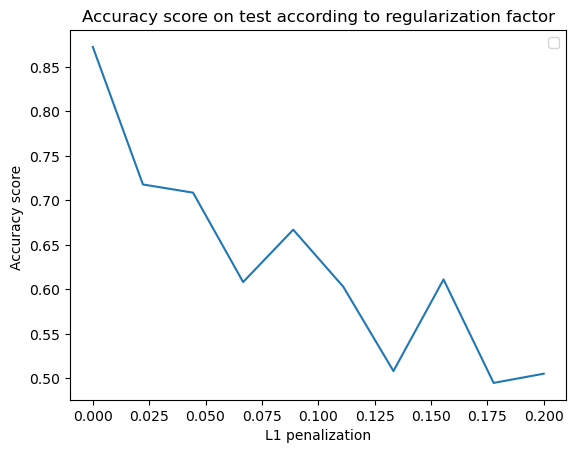

In [18]:
plt.plot(L1_eps_values, accuray_test_values)
plt.title("Accuracy score on test according to regularization factor")
plt.xlabel("L1 penalization")
plt.ylabel("Accuracy score ")
plt.legend()

Let's then remove the regularization factor.

In [19]:
B_values = np.linspace(1, 99, 10)
accuray_test_values = np.zeros(len(B_values))
for i, B_value in enumerate(B_values):
  inputs, encoder, bottleneck, decoder, model = build_AE(N, B_value, loss, activation, L1_eps=0.)
  model.fit(X_train, X_train, epochs=500, batch_size=64, validation_split=0.1, shuffle=False, callbacks=[early_stopping])
  ri_test_reconstructed = model.predict(X_test)
  accuray_test_values[i] = compute_frac(X_test, ri_test_reconstructed)

Epoch 1/500
47/47 [==============================] - 0s 3ms/step - loss: 9.9562e-04 - val_loss: 3.9684e-04
Epoch 2/500
47/47 [==============================] - 0s 1ms/step - loss: 5.9938e-04 - val_loss: 3.8966e-04
Epoch 3/500
47/47 [==============================] - 0s 1ms/step - loss: 5.9749e-04 - val_loss: 3.8933e-04
Epoch 4/500
47/47 [==============================] - 0s 1ms/step - loss: 5.9730e-04 - val_loss: 3.8906e-04
Epoch 5/500
47/47 [==============================] - 0s 979us/step - loss: 5.9704e-04 - val_loss: 3.8871e-04
Epoch 6/500
47/47 [==============================] - 0s 2ms/step - loss: 5.9666e-04 - val_loss: 3.8823e-04
Epoch 7/500
47/47 [==============================] - 0s 1ms/step - loss: 5.9611e-04 - val_loss: 3.8755e-04
Epoch 8/500
47/47 [==============================] - 0s 1ms/step - loss: 5.9530e-04 - val_loss: 3.8658e-04
Epoch 9/500
47/47 [==============================] - 0s 1ms/step - loss: 5.9409e-04 - val_loss: 3.8516e-04
Epoch 10/500
47/47 [===============

47/47 [==============================] - 0s 1ms/step - loss: 4.1859e-04 - val_loss: 2.2158e-04
Epoch 77/500
47/47 [==============================] - 0s 1ms/step - loss: 4.1855e-04 - val_loss: 2.2152e-04
Epoch 78/500
47/47 [==============================] - 0s 953us/step - loss: 4.1852e-04 - val_loss: 2.2146e-04
Epoch 79/500
47/47 [==============================] - 0s 2ms/step - loss: 4.1849e-04 - val_loss: 2.2142e-04
Epoch 80/500
47/47 [==============================] - 0s 1ms/step - loss: 4.1846e-04 - val_loss: 2.2138e-04
Epoch 81/500
47/47 [==============================] - 0s 788us/step - loss: 4.1844e-04 - val_loss: 2.2136e-04
Epoch 82/500
47/47 [==============================] - 0s 703us/step - loss: 4.1841e-04 - val_loss: 2.2134e-04
Epoch 83/500
47/47 [==============================] - 0s 844us/step - loss: 4.1839e-04 - val_loss: 2.2133e-04
Epoch 84/500
47/47 [==============================] - 0s 921us/step - loss: 4.1837e-04 - val_loss: 2.2132e-04
Epoch 85/500
47/47 [===========

47/47 [==============================] - 0s 891us/step - loss: 3.8308e-04 - val_loss: 2.0462e-04
Epoch 62/500
47/47 [==============================] - 0s 1ms/step - loss: 3.8199e-04 - val_loss: 2.0388e-04
Epoch 63/500
47/47 [==============================] - 0s 2ms/step - loss: 3.8090e-04 - val_loss: 2.0320e-04
Epoch 64/500
47/47 [==============================] - 0s 737us/step - loss: 3.7982e-04 - val_loss: 2.0258e-04
Epoch 65/500
47/47 [==============================] - 0s 2ms/step - loss: 3.7875e-04 - val_loss: 2.0201e-04
Epoch 66/500
47/47 [==============================] - 0s 994us/step - loss: 3.7768e-04 - val_loss: 2.0147e-04
Epoch 67/500
47/47 [==============================] - 0s 1ms/step - loss: 3.7661e-04 - val_loss: 2.0095e-04
Epoch 68/500
47/47 [==============================] - 0s 1ms/step - loss: 3.7554e-04 - val_loss: 2.0043e-04
Epoch 69/500
47/47 [==============================] - 0s 1ms/step - loss: 3.7447e-04 - val_loss: 1.9989e-04
Epoch 70/500
47/47 [===============

47/47 [==============================] - 0s 1ms/step - loss: 3.1646e-04 - val_loss: 1.7017e-04
Epoch 137/500
47/47 [==============================] - 0s 2ms/step - loss: 3.1586e-04 - val_loss: 1.6984e-04
Epoch 138/500
47/47 [==============================] - 0s 2ms/step - loss: 3.1527e-04 - val_loss: 1.6952e-04
Epoch 139/500
47/47 [==============================] - 0s 1ms/step - loss: 3.1468e-04 - val_loss: 1.6920e-04
Epoch 140/500
47/47 [==============================] - 0s 1ms/step - loss: 3.1410e-04 - val_loss: 1.6888e-04
Epoch 141/500
47/47 [==============================] - 0s 1ms/step - loss: 3.1353e-04 - val_loss: 1.6857e-04
Epoch 142/500
47/47 [==============================] - 0s 1ms/step - loss: 3.1296e-04 - val_loss: 1.6825e-04
Epoch 143/500
47/47 [==============================] - 0s 2ms/step - loss: 3.1240e-04 - val_loss: 1.6794e-04
Epoch 144/500
47/47 [==============================] - 0s 1ms/step - loss: 3.1185e-04 - val_loss: 1.6763e-04
Epoch 145/500
47/47 [============

47/47 [==============================] - 0s 1ms/step - loss: 2.8999e-04 - val_loss: 1.5552e-04
Epoch 212/500
47/47 [==============================] - 0s 885us/step - loss: 2.8983e-04 - val_loss: 1.5542e-04
Epoch 213/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8967e-04 - val_loss: 1.5533e-04
Epoch 214/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8952e-04 - val_loss: 1.5525e-04
Epoch 215/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8937e-04 - val_loss: 1.5516e-04
Epoch 216/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8922e-04 - val_loss: 1.5507e-04
Epoch 217/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8907e-04 - val_loss: 1.5499e-04
Epoch 218/500
47/47 [==============================] - 0s 804us/step - loss: 2.8893e-04 - val_loss: 1.5491e-04
Epoch 219/500
47/47 [==============================] - 0s 874us/step - loss: 2.8879e-04 - val_loss: 1.5483e-04
Epoch 220/500
47/47 [======

Epoch 286/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8319e-04 - val_loss: 1.5163e-04
Epoch 287/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8315e-04 - val_loss: 1.5160e-04
Epoch 288/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8310e-04 - val_loss: 1.5158e-04
Epoch 289/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8305e-04 - val_loss: 1.5155e-04
Epoch 290/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8301e-04 - val_loss: 1.5153e-04
Epoch 291/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8296e-04 - val_loss: 1.5150e-04
Epoch 292/500
47/47 [==============================] - 0s 839us/step - loss: 2.8292e-04 - val_loss: 1.5148e-04
Epoch 293/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8287e-04 - val_loss: 1.5146e-04
Epoch 294/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8283e-04 - val_loss: 1.5143e-04
Epoch 295/500
47/

Epoch 361/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8082e-04 - val_loss: 1.5055e-04
Epoch 362/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8079e-04 - val_loss: 1.5054e-04
Epoch 363/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8077e-04 - val_loss: 1.5053e-04
Epoch 364/500
47/47 [==============================] - 0s 876us/step - loss: 2.8075e-04 - val_loss: 1.5053e-04
Epoch 365/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8073e-04 - val_loss: 1.5052e-04
Epoch 366/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8071e-04 - val_loss: 1.5051e-04
Epoch 367/500
47/47 [==============================] - 0s 951us/step - loss: 2.8068e-04 - val_loss: 1.5051e-04
Epoch 368/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8066e-04 - val_loss: 1.5050e-04
Epoch 369/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8064e-04 - val_loss: 1.5049e-04
Epoch 370/500
4

Epoch 39/500
47/47 [==============================] - 0s 1ms/step - loss: 3.8218e-04 - val_loss: 2.0945e-04
Epoch 40/500
47/47 [==============================] - 0s 2ms/step - loss: 3.8014e-04 - val_loss: 2.0813e-04
Epoch 41/500
47/47 [==============================] - 0s 2ms/step - loss: 3.7820e-04 - val_loss: 2.0689e-04
Epoch 42/500
47/47 [==============================] - 0s 1ms/step - loss: 3.7634e-04 - val_loss: 2.0569e-04
Epoch 43/500
47/47 [==============================] - 0s 1ms/step - loss: 3.7454e-04 - val_loss: 2.0454e-04
Epoch 44/500
47/47 [==============================] - 0s 821us/step - loss: 3.7280e-04 - val_loss: 2.0342e-04
Epoch 45/500
47/47 [==============================] - 0s 844us/step - loss: 3.7109e-04 - val_loss: 2.0235e-04
Epoch 46/500
47/47 [==============================] - 0s 765us/step - loss: 3.6942e-04 - val_loss: 2.0133e-04
Epoch 47/500
47/47 [==============================] - 0s 822us/step - loss: 3.6778e-04 - val_loss: 2.0035e-04
Epoch 48/500
47/47 [

47/47 [==============================] - 0s 1ms/step - loss: 2.7986e-04 - val_loss: 1.5382e-04
Epoch 115/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7896e-04 - val_loss: 1.5330e-04
Epoch 116/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7808e-04 - val_loss: 1.5279e-04
Epoch 117/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7721e-04 - val_loss: 1.5229e-04
Epoch 118/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7635e-04 - val_loss: 1.5179e-04
Epoch 119/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7549e-04 - val_loss: 1.5129e-04
Epoch 120/500
47/47 [==============================] - 0s 2ms/step - loss: 2.7465e-04 - val_loss: 1.5080e-04
Epoch 121/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7382e-04 - val_loss: 1.5032e-04
Epoch 122/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7301e-04 - val_loss: 1.4984e-04
Epoch 123/500
47/47 [============

47/47 [==============================] - 0s 2ms/step - loss: 2.3484e-04 - val_loss: 1.2837e-04
Epoch 190/500
47/47 [==============================] - 0s 1ms/step - loss: 2.3445e-04 - val_loss: 1.2820e-04
Epoch 191/500
47/47 [==============================] - 0s 1ms/step - loss: 2.3407e-04 - val_loss: 1.2803e-04
Epoch 192/500
47/47 [==============================] - 0s 2ms/step - loss: 2.3370e-04 - val_loss: 1.2787e-04
Epoch 193/500
47/47 [==============================] - 0s 1ms/step - loss: 2.3333e-04 - val_loss: 1.2771e-04
Epoch 194/500
47/47 [==============================] - 0s 1ms/step - loss: 2.3296e-04 - val_loss: 1.2755e-04
Epoch 195/500
47/47 [==============================] - 0s 2ms/step - loss: 2.3260e-04 - val_loss: 1.2740e-04
Epoch 196/500
47/47 [==============================] - 0s 855us/step - loss: 2.3224e-04 - val_loss: 1.2725e-04
Epoch 197/500
47/47 [==============================] - 0s 1ms/step - loss: 2.3189e-04 - val_loss: 1.2710e-04
Epoch 198/500
47/47 [==========

47/47 [==============================] - 0s 1ms/step - loss: 2.1473e-04 - val_loss: 1.1965e-04
Epoch 265/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1455e-04 - val_loss: 1.1958e-04
Epoch 266/500
47/47 [==============================] - 0s 984us/step - loss: 2.1438e-04 - val_loss: 1.1952e-04
Epoch 267/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1422e-04 - val_loss: 1.1946e-04
Epoch 268/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1405e-04 - val_loss: 1.1940e-04
Epoch 269/500
47/47 [==============================] - 0s 948us/step - loss: 2.1389e-04 - val_loss: 1.1934e-04
Epoch 270/500
47/47 [==============================] - 0s 2ms/step - loss: 2.1373e-04 - val_loss: 1.1928e-04
Epoch 271/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1357e-04 - val_loss: 1.1922e-04
Epoch 272/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1342e-04 - val_loss: 1.1916e-04
Epoch 273/500
47/47 [========

47/47 [==============================] - 0s 2ms/step - loss: 2.0675e-04 - val_loss: 1.1630e-04
Epoch 340/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0669e-04 - val_loss: 1.1626e-04
Epoch 341/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0662e-04 - val_loss: 1.1623e-04
Epoch 342/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0656e-04 - val_loss: 1.1620e-04
Epoch 343/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0650e-04 - val_loss: 1.1617e-04
Epoch 344/500
47/47 [==============================] - 0s 946us/step - loss: 2.0644e-04 - val_loss: 1.1613e-04
Epoch 345/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0637e-04 - val_loss: 1.1610e-04
Epoch 346/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0631e-04 - val_loss: 1.1607e-04
Epoch 347/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0625e-04 - val_loss: 1.1604e-04
Epoch 348/500
47/47 [==========

47/47 [==============================] - 0s 2ms/step - loss: 2.0318e-04 - val_loss: 1.1411e-04
Epoch 415/500
47/47 [==============================] - 0s 956us/step - loss: 2.0315e-04 - val_loss: 1.1409e-04
Epoch 416/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0312e-04 - val_loss: 1.1408e-04
Epoch 417/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0308e-04 - val_loss: 1.1406e-04
Epoch 418/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0305e-04 - val_loss: 1.1405e-04
Epoch 419/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0302e-04 - val_loss: 1.1403e-04
Epoch 420/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0299e-04 - val_loss: 1.1401e-04
Epoch 421/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0296e-04 - val_loss: 1.1400e-04
Epoch 422/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0293e-04 - val_loss: 1.1398e-04
Epoch 423/500
47/47 [==========

Epoch 489/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0124e-04 - val_loss: 1.1249e-04
Epoch 490/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0122e-04 - val_loss: 1.1247e-04
Epoch 491/500
47/47 [==============================] - 0s 949us/step - loss: 2.0121e-04 - val_loss: 1.1246e-04
Epoch 492/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0119e-04 - val_loss: 1.1244e-04
Epoch 493/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0117e-04 - val_loss: 1.1243e-04
Epoch 494/500
47/47 [==============================] - 0s 973us/step - loss: 2.0115e-04 - val_loss: 1.1241e-04
Epoch 495/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0113e-04 - val_loss: 1.1240e-04
Epoch 496/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0111e-04 - val_loss: 1.1238e-04
Epoch 497/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0109e-04 - val_loss: 1.1237e-04
Epoch 498/500
4

47/47 [==============================] - 0s 2ms/step - loss: 3.2197e-04 - val_loss: 1.7186e-04
Epoch 65/500
47/47 [==============================] - 0s 1ms/step - loss: 3.2001e-04 - val_loss: 1.7075e-04
Epoch 66/500
47/47 [==============================] - 0s 1ms/step - loss: 3.1806e-04 - val_loss: 1.6965e-04
Epoch 67/500
47/47 [==============================] - 0s 2ms/step - loss: 3.1612e-04 - val_loss: 1.6858e-04
Epoch 68/500
47/47 [==============================] - 0s 2ms/step - loss: 3.1420e-04 - val_loss: 1.6755e-04
Epoch 69/500
47/47 [==============================] - 0s 2ms/step - loss: 3.1229e-04 - val_loss: 1.6656e-04
Epoch 70/500
47/47 [==============================] - 0s 1ms/step - loss: 3.1039e-04 - val_loss: 1.6559e-04
Epoch 71/500
47/47 [==============================] - 0s 2ms/step - loss: 3.0850e-04 - val_loss: 1.6465e-04
Epoch 72/500
47/47 [==============================] - 0s 2ms/step - loss: 3.0662e-04 - val_loss: 1.6373e-04
Epoch 73/500
47/47 [=====================

47/47 [==============================] - 0s 2ms/step - loss: 2.1829e-04 - val_loss: 1.1990e-04
Epoch 140/500
47/47 [==============================] - 0s 914us/step - loss: 2.1749e-04 - val_loss: 1.1950e-04
Epoch 141/500
47/47 [==============================] - 0s 2ms/step - loss: 2.1671e-04 - val_loss: 1.1910e-04
Epoch 142/500
47/47 [==============================] - 0s 2ms/step - loss: 2.1594e-04 - val_loss: 1.1872e-04
Epoch 143/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1518e-04 - val_loss: 1.1835e-04
Epoch 144/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1444e-04 - val_loss: 1.1798e-04
Epoch 145/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1370e-04 - val_loss: 1.1762e-04
Epoch 146/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1298e-04 - val_loss: 1.1725e-04
Epoch 147/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1227e-04 - val_loss: 1.1689e-04
Epoch 148/500
47/47 [==========

47/47 [==============================] - 0s 1ms/step - loss: 1.8182e-04 - val_loss: 1.0204e-04
Epoch 215/500
47/47 [==============================] - 0s 1ms/step - loss: 1.8153e-04 - val_loss: 1.0191e-04
Epoch 216/500
47/47 [==============================] - 0s 2ms/step - loss: 1.8125e-04 - val_loss: 1.0178e-04
Epoch 217/500
47/47 [==============================] - 0s 2ms/step - loss: 1.8096e-04 - val_loss: 1.0165e-04
Epoch 218/500
47/47 [==============================] - 0s 2ms/step - loss: 1.8068e-04 - val_loss: 1.0152e-04
Epoch 219/500
47/47 [==============================] - 0s 2ms/step - loss: 1.8040e-04 - val_loss: 1.0140e-04
Epoch 220/500
47/47 [==============================] - 0s 1ms/step - loss: 1.8013e-04 - val_loss: 1.0127e-04
Epoch 221/500
47/47 [==============================] - 0s 2ms/step - loss: 1.7986e-04 - val_loss: 1.0115e-04
Epoch 222/500
47/47 [==============================] - 0s 2ms/step - loss: 1.7959e-04 - val_loss: 1.0103e-04
Epoch 223/500
47/47 [============

47/47 [==============================] - 0s 892us/step - loss: 1.6600e-04 - val_loss: 9.3344e-05
Epoch 290/500
47/47 [==============================] - 0s 1ms/step - loss: 1.6584e-04 - val_loss: 9.3262e-05
Epoch 291/500
47/47 [==============================] - 0s 1ms/step - loss: 1.6569e-04 - val_loss: 9.3181e-05
Epoch 292/500
47/47 [==============================] - 0s 978us/step - loss: 1.6554e-04 - val_loss: 9.3100e-05
Epoch 293/500
47/47 [==============================] - 0s 2ms/step - loss: 1.6539e-04 - val_loss: 9.3020e-05
Epoch 294/500
47/47 [==============================] - 0s 1ms/step - loss: 1.6525e-04 - val_loss: 9.2940e-05
Epoch 295/500
47/47 [==============================] - 0s 956us/step - loss: 1.6510e-04 - val_loss: 9.2861e-05
Epoch 296/500
47/47 [==============================] - 0s 686us/step - loss: 1.6495e-04 - val_loss: 9.2783e-05
Epoch 297/500
47/47 [==============================] - 0s 1ms/step - loss: 1.6481e-04 - val_loss: 9.2705e-05
Epoch 298/500
47/47 [====

47/47 [==============================] - 0s 1ms/step - loss: 1.5708e-04 - val_loss: 8.8448e-05
Epoch 365/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5699e-04 - val_loss: 8.8401e-05
Epoch 366/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5690e-04 - val_loss: 8.8354e-05
Epoch 367/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5681e-04 - val_loss: 8.8308e-05
Epoch 368/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5672e-04 - val_loss: 8.8262e-05
Epoch 369/500
47/47 [==============================] - 0s 1ms/step - loss: 1.5663e-04 - val_loss: 8.8216e-05
Epoch 370/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5654e-04 - val_loss: 8.8171e-05
Epoch 371/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5645e-04 - val_loss: 8.8126e-05
Epoch 372/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5636e-04 - val_loss: 8.8081e-05
Epoch 373/500
47/47 [============

Epoch 439/500
47/47 [==============================] - 0s 814us/step - loss: 1.5127e-04 - val_loss: 8.5960e-05
Epoch 440/500
47/47 [==============================] - 0s 964us/step - loss: 1.5121e-04 - val_loss: 8.5956e-05
Epoch 441/500
47/47 [==============================] - 0s 908us/step - loss: 1.5116e-04 - val_loss: 8.5956e-05
Epoch 442/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5111e-04 - val_loss: 8.5961e-05
Epoch 443/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5106e-04 - val_loss: 8.5969e-05
Epoch 444/500
47/47 [==============================] - 0s 949us/step - loss: 1.5101e-04 - val_loss: 8.5975e-05
Epoch 445/500
13/13 [==============================] - 0s 383us/step
Epoch 1/500
47/47 [==============================] - 0s 3ms/step - loss: 0.0202 - val_loss: 6.2231e-04
Epoch 2/500
47/47 [==============================] - 0s 999us/step - loss: 6.3921e-04 - val_loss: 3.8120e-04
Epoch 3/500
47/47 [==============================] - 0s 1

47/47 [==============================] - 0s 2ms/step - loss: 2.8263e-04 - val_loss: 1.5778e-04
Epoch 70/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8056e-04 - val_loss: 1.5689e-04
Epoch 71/500
47/47 [==============================] - 0s 2ms/step - loss: 2.7850e-04 - val_loss: 1.5595e-04
Epoch 72/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7645e-04 - val_loss: 1.5496e-04
Epoch 73/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7441e-04 - val_loss: 1.5391e-04
Epoch 74/500
47/47 [==============================] - 0s 757us/step - loss: 2.7238e-04 - val_loss: 1.5283e-04
Epoch 75/500
47/47 [==============================] - 0s 952us/step - loss: 2.7036e-04 - val_loss: 1.5173e-04
Epoch 76/500
47/47 [==============================] - 0s 1ms/step - loss: 2.6836e-04 - val_loss: 1.5063e-04
Epoch 77/500
47/47 [==============================] - 0s 1ms/step - loss: 2.6636e-04 - val_loss: 1.4953e-04
Epoch 78/500
47/47 [=================

47/47 [==============================] - 0s 944us/step - loss: 1.7728e-04 - val_loss: 1.0176e-04
Epoch 145/500
47/47 [==============================] - 0s 856us/step - loss: 1.7644e-04 - val_loss: 1.0132e-04
Epoch 146/500
47/47 [==============================] - 0s 1ms/step - loss: 1.7561e-04 - val_loss: 1.0087e-04
Epoch 147/500
47/47 [==============================] - 0s 836us/step - loss: 1.7479e-04 - val_loss: 1.0043e-04
Epoch 148/500
47/47 [==============================] - 0s 1ms/step - loss: 1.7398e-04 - val_loss: 9.9987e-05
Epoch 149/500
47/47 [==============================] - 0s 981us/step - loss: 1.7318e-04 - val_loss: 9.9544e-05
Epoch 150/500
47/47 [==============================] - 0s 936us/step - loss: 1.7240e-04 - val_loss: 9.9100e-05
Epoch 151/500
47/47 [==============================] - 0s 900us/step - loss: 1.7162e-04 - val_loss: 9.8654e-05
Epoch 152/500
47/47 [==============================] - 0s 1ms/step - loss: 1.7086e-04 - val_loss: 9.8207e-05
Epoch 153/500
47/47 [

Epoch 219/500
47/47 [==============================] - 0s 2ms/step - loss: 1.3841e-04 - val_loss: 7.9571e-05
Epoch 220/500
47/47 [==============================] - 0s 2ms/step - loss: 1.3813e-04 - val_loss: 7.9424e-05
Epoch 221/500
47/47 [==============================] - 0s 1ms/step - loss: 1.3786e-04 - val_loss: 7.9279e-05
Epoch 222/500
47/47 [==============================] - 0s 1ms/step - loss: 1.3758e-04 - val_loss: 7.9136e-05
Epoch 223/500
47/47 [==============================] - 0s 1ms/step - loss: 1.3732e-04 - val_loss: 7.8995e-05
Epoch 224/500
47/47 [==============================] - 0s 1ms/step - loss: 1.3705e-04 - val_loss: 7.8855e-05
Epoch 225/500
47/47 [==============================] - 0s 2ms/step - loss: 1.3679e-04 - val_loss: 7.8717e-05
Epoch 226/500
47/47 [==============================] - 0s 2ms/step - loss: 1.3654e-04 - val_loss: 7.8579e-05
Epoch 227/500
47/47 [==============================] - 0s 1ms/step - loss: 1.3628e-04 - val_loss: 7.8443e-05
Epoch 228/500
47/47

Epoch 294/500
47/47 [==============================] - 0s 2ms/step - loss: 1.2487e-04 - val_loss: 7.2265e-05
Epoch 295/500
47/47 [==============================] - 0s 833us/step - loss: 1.2475e-04 - val_loss: 7.2206e-05
Epoch 296/500
47/47 [==============================] - 0s 959us/step - loss: 1.2464e-04 - val_loss: 7.2140e-05
Epoch 297/500
47/47 [==============================] - 0s 986us/step - loss: 1.2452e-04 - val_loss: 7.2065e-05
Epoch 298/500
47/47 [==============================] - 0s 2ms/step - loss: 1.2440e-04 - val_loss: 7.1981e-05
Epoch 299/500
47/47 [==============================] - 0s 2ms/step - loss: 1.2428e-04 - val_loss: 7.1893e-05
Epoch 300/500
47/47 [==============================] - 0s 2ms/step - loss: 1.2415e-04 - val_loss: 7.1807e-05
Epoch 301/500
47/47 [==============================] - 0s 2ms/step - loss: 1.2403e-04 - val_loss: 7.1726e-05
Epoch 302/500
47/47 [==============================] - 0s 989us/step - loss: 1.2391e-04 - val_loss: 7.1651e-05
Epoch 303/5

Epoch 369/500
47/47 [==============================] - 0s 857us/step - loss: 1.1802e-04 - val_loss: 6.8723e-05
Epoch 370/500
47/47 [==============================] - 0s 1ms/step - loss: 1.1796e-04 - val_loss: 6.8709e-05
Epoch 371/500
47/47 [==============================] - 0s 1ms/step - loss: 1.1790e-04 - val_loss: 6.8691e-05
Epoch 372/500
47/47 [==============================] - 0s 1ms/step - loss: 1.1783e-04 - val_loss: 6.8665e-05
Epoch 373/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1777e-04 - val_loss: 6.8632e-05
Epoch 374/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1770e-04 - val_loss: 6.8593e-05
Epoch 375/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1764e-04 - val_loss: 6.8546e-05
Epoch 376/500
47/47 [==============================] - 0s 886us/step - loss: 1.1757e-04 - val_loss: 6.8496e-05
Epoch 377/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1750e-04 - val_loss: 6.8442e-05
Epoch 378/500
4

47/47 [==============================] - 0s 2ms/step - loss: 1.1372e-04 - val_loss: 6.6410e-05
Epoch 445/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1368e-04 - val_loss: 6.6396e-05
Epoch 446/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1363e-04 - val_loss: 6.6379e-05
Epoch 447/500
47/47 [==============================] - 0s 1ms/step - loss: 1.1358e-04 - val_loss: 6.6359e-05
Epoch 448/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1353e-04 - val_loss: 6.6336e-05
Epoch 449/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1347e-04 - val_loss: 6.6309e-05
Epoch 450/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1342e-04 - val_loss: 6.6279e-05
Epoch 451/500
47/47 [==============================] - 0s 1ms/step - loss: 1.1337e-04 - val_loss: 6.6246e-05
Epoch 452/500
47/47 [==============================] - 0s 1ms/step - loss: 1.1332e-04 - val_loss: 6.6212e-05
Epoch 453/500
47/47 [============

Epoch 19/500
47/47 [==============================] - 0s 848us/step - loss: 4.2628e-04 - val_loss: 2.4515e-04
Epoch 20/500
47/47 [==============================] - 0s 1ms/step - loss: 4.1830e-04 - val_loss: 2.3895e-04
Epoch 21/500
47/47 [==============================] - 0s 1ms/step - loss: 4.1083e-04 - val_loss: 2.3328e-04
Epoch 22/500
47/47 [==============================] - 0s 1ms/step - loss: 4.0389e-04 - val_loss: 2.2811e-04
Epoch 23/500
47/47 [==============================] - 0s 1ms/step - loss: 3.9749e-04 - val_loss: 2.2340e-04
Epoch 24/500
47/47 [==============================] - 0s 2ms/step - loss: 3.9160e-04 - val_loss: 2.1913e-04
Epoch 25/500
47/47 [==============================] - 0s 2ms/step - loss: 3.8620e-04 - val_loss: 2.1528e-04
Epoch 26/500
47/47 [==============================] - 0s 932us/step - loss: 3.8123e-04 - val_loss: 2.1180e-04
Epoch 27/500
47/47 [==============================] - 0s 1ms/step - loss: 3.7666e-04 - val_loss: 2.0865e-04
Epoch 28/500
47/47 [====

47/47 [==============================] - 0s 2ms/step - loss: 2.2346e-04 - val_loss: 1.2708e-04
Epoch 95/500
47/47 [==============================] - 0s 2ms/step - loss: 2.2187e-04 - val_loss: 1.2629e-04
Epoch 96/500
47/47 [==============================] - 0s 1ms/step - loss: 2.2030e-04 - val_loss: 1.2552e-04
Epoch 97/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1876e-04 - val_loss: 1.2476e-04
Epoch 98/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1723e-04 - val_loss: 1.2399e-04
Epoch 99/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1573e-04 - val_loss: 1.2323e-04
Epoch 100/500
47/47 [==============================] - 0s 2ms/step - loss: 2.1424e-04 - val_loss: 1.2245e-04
Epoch 101/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1276e-04 - val_loss: 1.2167e-04
Epoch 102/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1130e-04 - val_loss: 1.2088e-04
Epoch 103/500
47/47 [=================

47/47 [==============================] - 0s 1ms/step - loss: 1.4100e-04 - val_loss: 8.5366e-05
Epoch 170/500
47/47 [==============================] - 0s 1ms/step - loss: 1.4029e-04 - val_loss: 8.4976e-05
Epoch 171/500
47/47 [==============================] - 0s 1ms/step - loss: 1.3960e-04 - val_loss: 8.4586e-05
Epoch 172/500
47/47 [==============================] - 0s 1ms/step - loss: 1.3892e-04 - val_loss: 8.4196e-05
Epoch 173/500
47/47 [==============================] - 0s 2ms/step - loss: 1.3824e-04 - val_loss: 8.3806e-05
Epoch 174/500
47/47 [==============================] - 0s 1ms/step - loss: 1.3758e-04 - val_loss: 8.3415e-05
Epoch 175/500
47/47 [==============================] - 0s 830us/step - loss: 1.3692e-04 - val_loss: 8.3024e-05
Epoch 176/500
47/47 [==============================] - 0s 880us/step - loss: 1.3627e-04 - val_loss: 8.2634e-05
Epoch 177/500
47/47 [==============================] - 0s 1ms/step - loss: 1.3562e-04 - val_loss: 8.2245e-05
Epoch 178/500
47/47 [========

47/47 [==============================] - 0s 3ms/step - loss: 1.0522e-04 - val_loss: 6.4026e-05
Epoch 245/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0491e-04 - val_loss: 6.3843e-05
Epoch 246/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0460e-04 - val_loss: 6.3665e-05
Epoch 247/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0430e-04 - val_loss: 6.3490e-05
Epoch 248/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0400e-04 - val_loss: 6.3318e-05
Epoch 249/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0371e-04 - val_loss: 6.3151e-05
Epoch 250/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0342e-04 - val_loss: 6.2986e-05
Epoch 251/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0313e-04 - val_loss: 6.2826e-05
Epoch 252/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0284e-04 - val_loss: 6.2668e-05
Epoch 253/500
47/47 [============

47/47 [==============================] - 0s 987us/step - loss: 9.0551e-05 - val_loss: 5.5377e-05
Epoch 320/500
47/47 [==============================] - 0s 790us/step - loss: 9.0447e-05 - val_loss: 5.5360e-05
Epoch 321/500
47/47 [==============================] - 0s 900us/step - loss: 9.0345e-05 - val_loss: 5.5358e-05
Epoch 322/500
47/47 [==============================] - 0s 1ms/step - loss: 9.0242e-05 - val_loss: 5.5360e-05
Epoch 323/500
47/47 [==============================] - 0s 1ms/step - loss: 9.0139e-05 - val_loss: 5.5355e-05
Epoch 324/500
47/47 [==============================] - 0s 2ms/step - loss: 9.0033e-05 - val_loss: 5.5325e-05
Epoch 325/500
47/47 [==============================] - 0s 1ms/step - loss: 8.9925e-05 - val_loss: 5.5264e-05
Epoch 326/500
47/47 [==============================] - 0s 1ms/step - loss: 8.9814e-05 - val_loss: 5.5174e-05
Epoch 327/500
47/47 [==============================] - 0s 2ms/step - loss: 8.9701e-05 - val_loss: 5.5073e-05
Epoch 328/500
47/47 [======

47/47 [==============================] - 0s 1ms/step - loss: 8.4474e-05 - val_loss: 5.1475e-05
Epoch 395/500
47/47 [==============================] - 0s 1ms/step - loss: 8.4408e-05 - val_loss: 5.1429e-05
Epoch 396/500
47/47 [==============================] - 0s 1ms/step - loss: 8.4344e-05 - val_loss: 5.1386e-05
Epoch 397/500
47/47 [==============================] - 0s 2ms/step - loss: 8.4281e-05 - val_loss: 5.1347e-05
Epoch 398/500
47/47 [==============================] - 0s 1ms/step - loss: 8.4221e-05 - val_loss: 5.1311e-05
Epoch 399/500
47/47 [==============================] - 0s 2ms/step - loss: 8.4161e-05 - val_loss: 5.1279e-05
Epoch 400/500
47/47 [==============================] - 0s 1ms/step - loss: 8.4104e-05 - val_loss: 5.1249e-05
Epoch 401/500
47/47 [==============================] - 0s 1ms/step - loss: 8.4048e-05 - val_loss: 5.1220e-05
Epoch 402/500
47/47 [==============================] - 0s 2ms/step - loss: 8.3995e-05 - val_loss: 5.1190e-05
Epoch 403/500
47/47 [============

47/47 [==============================] - 0s 1ms/step - loss: 8.0790e-05 - val_loss: 4.8597e-05
Epoch 470/500
47/47 [==============================] - 0s 2ms/step - loss: 8.0748e-05 - val_loss: 4.8561e-05
Epoch 471/500
47/47 [==============================] - 0s 2ms/step - loss: 8.0707e-05 - val_loss: 4.8523e-05
Epoch 472/500
47/47 [==============================] - 0s 942us/step - loss: 8.0664e-05 - val_loss: 4.8483e-05
Epoch 473/500
47/47 [==============================] - 0s 2ms/step - loss: 8.0622e-05 - val_loss: 4.8443e-05
Epoch 474/500
47/47 [==============================] - 0s 893us/step - loss: 8.0579e-05 - val_loss: 4.8404e-05
Epoch 475/500
47/47 [==============================] - 0s 933us/step - loss: 8.0537e-05 - val_loss: 4.8367e-05
Epoch 476/500
47/47 [==============================] - 0s 2ms/step - loss: 8.0495e-05 - val_loss: 4.8332e-05
Epoch 477/500
47/47 [==============================] - 0s 1ms/step - loss: 8.0453e-05 - val_loss: 4.8298e-05
Epoch 478/500
47/47 [======

47/47 [==============================] - 0s 3ms/step - loss: 3.2355e-04 - val_loss: 1.7696e-04
Epoch 45/500
47/47 [==============================] - 0s 2ms/step - loss: 3.2108e-04 - val_loss: 1.7573e-04
Epoch 46/500
47/47 [==============================] - 0s 2ms/step - loss: 3.1862e-04 - val_loss: 1.7452e-04
Epoch 47/500
47/47 [==============================] - 0s 3ms/step - loss: 3.1616e-04 - val_loss: 1.7332e-04
Epoch 48/500
47/47 [==============================] - 0s 2ms/step - loss: 3.1369e-04 - val_loss: 1.7209e-04
Epoch 49/500
47/47 [==============================] - 0s 2ms/step - loss: 3.1121e-04 - val_loss: 1.7084e-04
Epoch 50/500
47/47 [==============================] - 0s 3ms/step - loss: 3.0872e-04 - val_loss: 1.6960e-04
Epoch 51/500
47/47 [==============================] - 0s 3ms/step - loss: 3.0623e-04 - val_loss: 1.6840e-04
Epoch 52/500
47/47 [==============================] - 0s 2ms/step - loss: 3.0375e-04 - val_loss: 1.6726e-04
Epoch 53/500
47/47 [=====================

Epoch 120/500
47/47 [==============================] - 0s 3ms/step - loss: 1.6819e-04 - val_loss: 9.8785e-05
Epoch 121/500
47/47 [==============================] - 0s 2ms/step - loss: 1.6686e-04 - val_loss: 9.8096e-05
Epoch 122/500
47/47 [==============================] - 0s 2ms/step - loss: 1.6556e-04 - val_loss: 9.7427e-05
Epoch 123/500
47/47 [==============================] - 0s 2ms/step - loss: 1.6427e-04 - val_loss: 9.6776e-05
Epoch 124/500
47/47 [==============================] - 0s 2ms/step - loss: 1.6300e-04 - val_loss: 9.6139e-05
Epoch 125/500
47/47 [==============================] - 0s 2ms/step - loss: 1.6175e-04 - val_loss: 9.5509e-05
Epoch 126/500
47/47 [==============================] - 0s 3ms/step - loss: 1.6052e-04 - val_loss: 9.4881e-05
Epoch 127/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5930e-04 - val_loss: 9.4249e-05
Epoch 128/500
47/47 [==============================] - 0s 1ms/step - loss: 1.5811e-04 - val_loss: 9.3610e-05
Epoch 129/500
47/47

47/47 [==============================] - 0s 2ms/step - loss: 1.0343e-04 - val_loss: 6.2338e-05
Epoch 196/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0289e-04 - val_loss: 6.2036e-05
Epoch 197/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0236e-04 - val_loss: 6.1737e-05
Epoch 198/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0184e-04 - val_loss: 6.1441e-05
Epoch 199/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0132e-04 - val_loss: 6.1149e-05
Epoch 200/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0081e-04 - val_loss: 6.0860e-05
Epoch 201/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0030e-04 - val_loss: 6.0574e-05
Epoch 202/500
47/47 [==============================] - 0s 2ms/step - loss: 9.9795e-05 - val_loss: 6.0292e-05
Epoch 203/500
47/47 [==============================] - 0s 2ms/step - loss: 9.9297e-05 - val_loss: 6.0012e-05
Epoch 204/500
47/47 [============

47/47 [==============================] - 0s 3ms/step - loss: 7.5180e-05 - val_loss: 4.6630e-05
Epoch 271/500
47/47 [==============================] - 0s 2ms/step - loss: 7.4933e-05 - val_loss: 4.6500e-05
Epoch 272/500
47/47 [==============================] - 0s 1ms/step - loss: 7.4689e-05 - val_loss: 4.6373e-05
Epoch 273/500
47/47 [==============================] - 0s 3ms/step - loss: 7.4449e-05 - val_loss: 4.6249e-05
Epoch 274/500
47/47 [==============================] - 0s 2ms/step - loss: 7.4211e-05 - val_loss: 4.6129e-05
Epoch 275/500
47/47 [==============================] - 0s 1ms/step - loss: 7.3976e-05 - val_loss: 4.6012e-05
Epoch 276/500
47/47 [==============================] - 0s 2ms/step - loss: 7.3744e-05 - val_loss: 4.5897e-05
Epoch 277/500
47/47 [==============================] - 0s 3ms/step - loss: 7.3515e-05 - val_loss: 4.5785e-05
Epoch 278/500
47/47 [==============================] - 0s 2ms/step - loss: 7.3288e-05 - val_loss: 4.5676e-05
Epoch 279/500
47/47 [============

47/47 [==============================] - 0s 3ms/step - loss: 5.0855e-04 - val_loss: 3.1673e-04
Epoch 10/500
47/47 [==============================] - 0s 2ms/step - loss: 4.9815e-04 - val_loss: 3.0845e-04
Epoch 11/500
47/47 [==============================] - 0s 2ms/step - loss: 4.8783e-04 - val_loss: 3.0028e-04
Epoch 12/500
47/47 [==============================] - 0s 2ms/step - loss: 4.7771e-04 - val_loss: 2.9231e-04
Epoch 13/500
47/47 [==============================] - 0s 3ms/step - loss: 4.6787e-04 - val_loss: 2.8464e-04
Epoch 14/500
47/47 [==============================] - 0s 2ms/step - loss: 4.5840e-04 - val_loss: 2.7729e-04
Epoch 15/500
47/47 [==============================] - 0s 3ms/step - loss: 4.4937e-04 - val_loss: 2.7029e-04
Epoch 16/500
47/47 [==============================] - 0s 3ms/step - loss: 4.4082e-04 - val_loss: 2.6368e-04
Epoch 17/500
47/47 [==============================] - 0s 1ms/step - loss: 4.3276e-04 - val_loss: 2.5747e-04
Epoch 18/500
47/47 [=====================

Epoch 85/500
47/47 [==============================] - 0s 6ms/step - loss: 2.2166e-04 - val_loss: 1.3089e-04
Epoch 86/500
47/47 [==============================] - 0s 4ms/step - loss: 2.1964e-04 - val_loss: 1.2998e-04
Epoch 87/500
47/47 [==============================] - 0s 3ms/step - loss: 2.1763e-04 - val_loss: 1.2903e-04
Epoch 88/500
47/47 [==============================] - 0s 2ms/step - loss: 2.1561e-04 - val_loss: 1.2804e-04
Epoch 89/500
47/47 [==============================] - 0s 6ms/step - loss: 2.1360e-04 - val_loss: 1.2701e-04
Epoch 90/500
47/47 [==============================] - 0s 4ms/step - loss: 2.1159e-04 - val_loss: 1.2593e-04
Epoch 91/500
47/47 [==============================] - 0s 5ms/step - loss: 2.0959e-04 - val_loss: 1.2480e-04
Epoch 92/500
47/47 [==============================] - 0s 3ms/step - loss: 2.0761e-04 - val_loss: 1.2360e-04
Epoch 93/500
47/47 [==============================] - 0s 6ms/step - loss: 2.0564e-04 - val_loss: 1.2234e-04
Epoch 94/500
47/47 [========

47/47 [==============================] - 0s 2ms/step - loss: 1.1732e-04 - val_loss: 7.3040e-05
Epoch 161/500
47/47 [==============================] - 0s 1ms/step - loss: 1.1645e-04 - val_loss: 7.2548e-05
Epoch 162/500
47/47 [==============================] - 0s 960us/step - loss: 1.1560e-04 - val_loss: 7.2062e-05
Epoch 163/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1476e-04 - val_loss: 7.1582e-05
Epoch 164/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1392e-04 - val_loss: 7.1105e-05
Epoch 165/500
47/47 [==============================] - 0s 1ms/step - loss: 1.1310e-04 - val_loss: 7.0632e-05
Epoch 166/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1228e-04 - val_loss: 7.0161e-05
Epoch 167/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1148e-04 - val_loss: 6.9691e-05
Epoch 168/500
47/47 [==============================] - 0s 1ms/step - loss: 1.1068e-04 - val_loss: 6.9220e-05
Epoch 169/500
47/47 [==========

47/47 [==============================] - 0s 2ms/step - loss: 7.4765e-05 - val_loss: 4.8414e-05
Epoch 236/500
47/47 [==============================] - 0s 2ms/step - loss: 7.4417e-05 - val_loss: 4.8221e-05
Epoch 237/500
47/47 [==============================] - 0s 2ms/step - loss: 7.4072e-05 - val_loss: 4.8029e-05
Epoch 238/500
47/47 [==============================] - 0s 1ms/step - loss: 7.3730e-05 - val_loss: 4.7839e-05
Epoch 239/500
47/47 [==============================] - 0s 2ms/step - loss: 7.3391e-05 - val_loss: 4.7650e-05
Epoch 240/500
47/47 [==============================] - 0s 2ms/step - loss: 7.3055e-05 - val_loss: 4.7463e-05
Epoch 241/500
47/47 [==============================] - 0s 2ms/step - loss: 7.2723e-05 - val_loss: 4.7277e-05
Epoch 242/500
47/47 [==============================] - 0s 2ms/step - loss: 7.2393e-05 - val_loss: 4.7092e-05
Epoch 243/500
47/47 [==============================] - 0s 2ms/step - loss: 7.2068e-05 - val_loss: 4.6907e-05
Epoch 244/500
47/47 [============

47/47 [==============================] - 0s 1ms/step - loss: 5.6017e-05 - val_loss: 3.7218e-05
Epoch 311/500
47/47 [==============================] - 0s 2ms/step - loss: 5.5840e-05 - val_loss: 3.7158e-05
Epoch 312/500
47/47 [==============================] - 0s 2ms/step - loss: 5.5664e-05 - val_loss: 3.7102e-05
Epoch 313/500
47/47 [==============================] - 0s 2ms/step - loss: 5.5490e-05 - val_loss: 3.7049e-05
Epoch 314/500
47/47 [==============================] - 0s 2ms/step - loss: 5.5316e-05 - val_loss: 3.6994e-05
Epoch 315/500
47/47 [==============================] - 0s 1ms/step - loss: 5.5142e-05 - val_loss: 3.6932e-05
Epoch 316/500
47/47 [==============================] - 0s 2ms/step - loss: 5.4968e-05 - val_loss: 3.6854e-05
Epoch 317/500
47/47 [==============================] - 0s 2ms/step - loss: 5.4791e-05 - val_loss: 3.6756e-05
Epoch 318/500
47/47 [==============================] - 0s 1ms/step - loss: 5.4614e-05 - val_loss: 3.6635e-05
Epoch 319/500
47/47 [============

47/47 [==============================] - 0s 2ms/step - loss: 4.5196e-05 - val_loss: 3.0939e-05
Epoch 386/500
47/47 [==============================] - 0s 2ms/step - loss: 4.5095e-05 - val_loss: 3.0878e-05
Epoch 387/500
47/47 [==============================] - 0s 2ms/step - loss: 4.4996e-05 - val_loss: 3.0815e-05
Epoch 388/500
47/47 [==============================] - 0s 1ms/step - loss: 4.4897e-05 - val_loss: 3.0749e-05
Epoch 389/500
47/47 [==============================] - 0s 1ms/step - loss: 4.4800e-05 - val_loss: 3.0682e-05
Epoch 390/500
47/47 [==============================] - 0s 2ms/step - loss: 4.4703e-05 - val_loss: 3.0613e-05
Epoch 391/500
47/47 [==============================] - 0s 2ms/step - loss: 4.4606e-05 - val_loss: 3.0543e-05
Epoch 392/500
47/47 [==============================] - 0s 2ms/step - loss: 4.4511e-05 - val_loss: 3.0473e-05
Epoch 393/500
47/47 [==============================] - 0s 1ms/step - loss: 4.4415e-05 - val_loss: 3.0403e-05
Epoch 394/500
47/47 [============

47/47 [==============================] - 0s 1ms/step - loss: 3.8785e-05 - val_loss: 2.6542e-05
Epoch 461/500
47/47 [==============================] - 0s 2ms/step - loss: 3.8707e-05 - val_loss: 2.6453e-05
Epoch 462/500
47/47 [==============================] - 0s 2ms/step - loss: 3.8630e-05 - val_loss: 2.6361e-05
Epoch 463/500
47/47 [==============================] - 0s 2ms/step - loss: 3.8553e-05 - val_loss: 2.6270e-05
Epoch 464/500
47/47 [==============================] - 0s 2ms/step - loss: 3.8478e-05 - val_loss: 2.6183e-05
Epoch 465/500
47/47 [==============================] - 0s 1ms/step - loss: 3.8404e-05 - val_loss: 2.6102e-05
Epoch 466/500
47/47 [==============================] - 0s 1ms/step - loss: 3.8332e-05 - val_loss: 2.6028e-05
Epoch 467/500
47/47 [==============================] - 0s 2ms/step - loss: 3.8260e-05 - val_loss: 2.5961e-05
Epoch 468/500
47/47 [==============================] - 0s 2ms/step - loss: 3.8190e-05 - val_loss: 2.5900e-05
Epoch 469/500
47/47 [============

47/47 [==============================] - 0s 2ms/step - loss: 3.2035e-04 - val_loss: 1.7657e-04
Epoch 42/500
47/47 [==============================] - 0s 2ms/step - loss: 3.1739e-04 - val_loss: 1.7536e-04
Epoch 43/500
47/47 [==============================] - 0s 1ms/step - loss: 3.1443e-04 - val_loss: 1.7421e-04
Epoch 44/500
47/47 [==============================] - 0s 1ms/step - loss: 3.1148e-04 - val_loss: 1.7308e-04
Epoch 45/500
47/47 [==============================] - 0s 2ms/step - loss: 3.0854e-04 - val_loss: 1.7194e-04
Epoch 46/500
47/47 [==============================] - 0s 923us/step - loss: 3.0563e-04 - val_loss: 1.7073e-04
Epoch 47/500
47/47 [==============================] - 0s 1ms/step - loss: 3.0275e-04 - val_loss: 1.6945e-04
Epoch 48/500
47/47 [==============================] - 0s 1ms/step - loss: 2.9989e-04 - val_loss: 1.6808e-04
Epoch 49/500
47/47 [==============================] - 0s 1ms/step - loss: 2.9705e-04 - val_loss: 1.6666e-04
Epoch 50/500
47/47 [===================

Epoch 117/500
47/47 [==============================] - 0s 1ms/step - loss: 1.5301e-04 - val_loss: 9.2911e-05
Epoch 118/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5164e-04 - val_loss: 9.2021e-05
Epoch 119/500
47/47 [==============================] - 0s 2ms/step - loss: 1.5028e-04 - val_loss: 9.1137e-05
Epoch 120/500
47/47 [==============================] - 0s 2ms/step - loss: 1.4893e-04 - val_loss: 9.0269e-05
Epoch 121/500
47/47 [==============================] - 0s 2ms/step - loss: 1.4760e-04 - val_loss: 8.9425e-05
Epoch 122/500
47/47 [==============================] - 0s 2ms/step - loss: 1.4629e-04 - val_loss: 8.8610e-05
Epoch 123/500
47/47 [==============================] - 0s 2ms/step - loss: 1.4500e-04 - val_loss: 8.7826e-05
Epoch 124/500
47/47 [==============================] - 0s 1ms/step - loss: 1.4372e-04 - val_loss: 8.7075e-05
Epoch 125/500
47/47 [==============================] - 0s 1ms/step - loss: 1.4246e-04 - val_loss: 8.6356e-05
Epoch 126/500
47/47

47/47 [==============================] - 0s 2ms/step - loss: 8.6142e-05 - val_loss: 5.2709e-05
Epoch 193/500
47/47 [==============================] - 0s 1ms/step - loss: 8.5580e-05 - val_loss: 5.2398e-05
Epoch 194/500
47/47 [==============================] - 0s 1ms/step - loss: 8.5024e-05 - val_loss: 5.2094e-05
Epoch 195/500
47/47 [==============================] - 0s 2ms/step - loss: 8.4473e-05 - val_loss: 5.1795e-05
Epoch 196/500
47/47 [==============================] - 0s 976us/step - loss: 8.3927e-05 - val_loss: 5.1502e-05
Epoch 197/500
47/47 [==============================] - 0s 1ms/step - loss: 8.3386e-05 - val_loss: 5.1214e-05
Epoch 198/500
47/47 [==============================] - 0s 2ms/step - loss: 8.2851e-05 - val_loss: 5.0930e-05
Epoch 199/500
47/47 [==============================] - 0s 2ms/step - loss: 8.2320e-05 - val_loss: 5.0650e-05
Epoch 200/500
47/47 [==============================] - 0s 2ms/step - loss: 8.1795e-05 - val_loss: 5.0373e-05
Epoch 201/500
47/47 [==========

47/47 [==============================] - 0s 2ms/step - loss: 5.5503e-05 - val_loss: 3.5562e-05
Epoch 268/500
47/47 [==============================] - 0s 1ms/step - loss: 5.5211e-05 - val_loss: 3.5383e-05
Epoch 269/500
47/47 [==============================] - 0s 1ms/step - loss: 5.4920e-05 - val_loss: 3.5208e-05
Epoch 270/500
47/47 [==============================] - 0s 2ms/step - loss: 5.4632e-05 - val_loss: 3.5038e-05
Epoch 271/500
47/47 [==============================] - 0s 961us/step - loss: 5.4345e-05 - val_loss: 3.4873e-05
Epoch 272/500
47/47 [==============================] - 0s 1ms/step - loss: 5.4061e-05 - val_loss: 3.4712e-05
Epoch 273/500
47/47 [==============================] - 0s 963us/step - loss: 5.3779e-05 - val_loss: 3.4555e-05
Epoch 274/500
47/47 [==============================] - 0s 1ms/step - loss: 5.3499e-05 - val_loss: 3.4403e-05
Epoch 275/500
47/47 [==============================] - 0s 1ms/step - loss: 5.3220e-05 - val_loss: 3.4254e-05
Epoch 276/500
47/47 [========

47/47 [==============================] - 0s 1ms/step - loss: 3.9817e-05 - val_loss: 2.7266e-05
Epoch 343/500
47/47 [==============================] - 0s 2ms/step - loss: 3.9685e-05 - val_loss: 2.7022e-05
Epoch 344/500
47/47 [==============================] - 0s 1ms/step - loss: 3.9532e-05 - val_loss: 2.6684e-05
Epoch 345/500
47/47 [==============================] - 0s 1ms/step - loss: 3.9387e-05 - val_loss: 2.6478e-05
Epoch 346/500
47/47 [==============================] - 0s 2ms/step - loss: 3.9220e-05 - val_loss: 2.6145e-05
Epoch 347/500
47/47 [==============================] - 0s 2ms/step - loss: 3.9004e-05 - val_loss: 2.5899e-05
Epoch 348/500
47/47 [==============================] - 0s 2ms/step - loss: 3.8780e-05 - val_loss: 2.5768e-05
Epoch 349/500
47/47 [==============================] - 0s 1ms/step - loss: 3.8582e-05 - val_loss: 2.5643e-05
Epoch 350/500
47/47 [==============================] - 0s 1ms/step - loss: 3.8407e-05 - val_loss: 2.5516e-05
Epoch 351/500
47/47 [============

47/47 [==============================] - 0s 2ms/step - loss: 3.7153e-04 - val_loss: 2.0753e-04
Epoch 26/500
47/47 [==============================] - 0s 2ms/step - loss: 3.6733e-04 - val_loss: 2.0508e-04
Epoch 27/500
47/47 [==============================] - 0s 1ms/step - loss: 3.6336e-04 - val_loss: 2.0288e-04
Epoch 28/500
47/47 [==============================] - 0s 2ms/step - loss: 3.5959e-04 - val_loss: 2.0083e-04
Epoch 29/500
47/47 [==============================] - 0s 2ms/step - loss: 3.5599e-04 - val_loss: 1.9886e-04
Epoch 30/500
47/47 [==============================] - 0s 2ms/step - loss: 3.5252e-04 - val_loss: 1.9694e-04
Epoch 31/500
47/47 [==============================] - 0s 2ms/step - loss: 3.4916e-04 - val_loss: 1.9505e-04
Epoch 32/500
47/47 [==============================] - 0s 2ms/step - loss: 3.4588e-04 - val_loss: 1.9318e-04
Epoch 33/500
47/47 [==============================] - 0s 1ms/step - loss: 3.4267e-04 - val_loss: 1.9128e-04
Epoch 34/500
47/47 [=====================

Epoch 101/500
47/47 [==============================] - 0s 2ms/step - loss: 1.7513e-04 - val_loss: 1.0776e-04
Epoch 102/500
47/47 [==============================] - 0s 1ms/step - loss: 1.7348e-04 - val_loss: 1.0675e-04
Epoch 103/500
47/47 [==============================] - 0s 1ms/step - loss: 1.7184e-04 - val_loss: 1.0572e-04
Epoch 104/500
47/47 [==============================] - 0s 2ms/step - loss: 1.7022e-04 - val_loss: 1.0465e-04
Epoch 105/500
47/47 [==============================] - 0s 2ms/step - loss: 1.6860e-04 - val_loss: 1.0355e-04
Epoch 106/500
47/47 [==============================] - 0s 2ms/step - loss: 1.6700e-04 - val_loss: 1.0241e-04
Epoch 107/500
47/47 [==============================] - 0s 2ms/step - loss: 1.6541e-04 - val_loss: 1.0122e-04
Epoch 108/500
47/47 [==============================] - 0s 1ms/step - loss: 1.6382e-04 - val_loss: 1.0001e-04
Epoch 109/500
47/47 [==============================] - 0s 2ms/step - loss: 1.6224e-04 - val_loss: 9.8785e-05
Epoch 110/500
47/47

47/47 [==============================] - 0s 2ms/step - loss: 9.1297e-05 - val_loss: 5.8044e-05
Epoch 177/500
47/47 [==============================] - 0s 2ms/step - loss: 9.0622e-05 - val_loss: 5.7543e-05
Epoch 178/500
47/47 [==============================] - 0s 2ms/step - loss: 8.9952e-05 - val_loss: 5.7046e-05
Epoch 179/500
47/47 [==============================] - 0s 2ms/step - loss: 8.9288e-05 - val_loss: 5.6555e-05
Epoch 180/500
47/47 [==============================] - 0s 1ms/step - loss: 8.8630e-05 - val_loss: 5.6073e-05
Epoch 181/500
47/47 [==============================] - 0s 2ms/step - loss: 8.7977e-05 - val_loss: 5.5604e-05
Epoch 182/500
47/47 [==============================] - 0s 2ms/step - loss: 8.7327e-05 - val_loss: 5.5150e-05
Epoch 183/500
47/47 [==============================] - 0s 2ms/step - loss: 8.6682e-05 - val_loss: 5.4715e-05
Epoch 184/500
47/47 [==============================] - 0s 2ms/step - loss: 8.6040e-05 - val_loss: 5.4302e-05
Epoch 185/500
47/47 [============

47/47 [==============================] - 0s 1ms/step - loss: 5.5439e-05 - val_loss: 3.5968e-05
Epoch 252/500
47/47 [==============================] - 0s 1ms/step - loss: 5.5128e-05 - val_loss: 3.5712e-05
Epoch 253/500
47/47 [==============================] - 0s 1ms/step - loss: 5.4819e-05 - val_loss: 3.5461e-05
Epoch 254/500
47/47 [==============================] - 0s 2ms/step - loss: 5.4512e-05 - val_loss: 3.5213e-05
Epoch 255/500
47/47 [==============================] - 0s 2ms/step - loss: 5.4207e-05 - val_loss: 3.4967e-05
Epoch 256/500
47/47 [==============================] - 0s 2ms/step - loss: 5.3904e-05 - val_loss: 3.4725e-05
Epoch 257/500
47/47 [==============================] - 0s 2ms/step - loss: 5.3603e-05 - val_loss: 3.4485e-05
Epoch 258/500
47/47 [==============================] - 0s 2ms/step - loss: 5.3304e-05 - val_loss: 3.4248e-05
Epoch 259/500
47/47 [==============================] - 0s 2ms/step - loss: 5.3008e-05 - val_loss: 3.4014e-05
Epoch 260/500
47/47 [============

47/47 [==============================] - 0s 1ms/step - loss: 3.8108e-05 - val_loss: 2.5228e-05
Epoch 327/500
47/47 [==============================] - 0s 2ms/step - loss: 3.7942e-05 - val_loss: 2.5147e-05
Epoch 328/500
47/47 [==============================] - 0s 2ms/step - loss: 3.7781e-05 - val_loss: 2.5072e-05
Epoch 329/500
47/47 [==============================] - 0s 2ms/step - loss: 3.7624e-05 - val_loss: 2.5001e-05
Epoch 330/500
47/47 [==============================] - 0s 1ms/step - loss: 3.7472e-05 - val_loss: 2.4932e-05
Epoch 331/500
47/47 [==============================] - 0s 1ms/step - loss: 3.7322e-05 - val_loss: 2.4851e-05
Epoch 332/500
47/47 [==============================] - 0s 1ms/step - loss: 3.7169e-05 - val_loss: 2.4734e-05
Epoch 333/500
47/47 [==============================] - 0s 2ms/step - loss: 3.7004e-05 - val_loss: 2.4570e-05
Epoch 334/500
47/47 [==============================] - 0s 2ms/step - loss: 3.6818e-05 - val_loss: 2.4397e-05
Epoch 335/500
47/47 [============

47/47 [==============================] - 0s 2ms/step - loss: 2.8146e-05 - val_loss: 1.9236e-05
Epoch 402/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8061e-05 - val_loss: 1.9219e-05
Epoch 403/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7977e-05 - val_loss: 1.9198e-05
Epoch 404/500
47/47 [==============================] - 0s 2ms/step - loss: 2.7895e-05 - val_loss: 1.9172e-05
Epoch 405/500
47/47 [==============================] - 0s 2ms/step - loss: 2.7815e-05 - val_loss: 1.9137e-05
Epoch 406/500
47/47 [==============================] - 0s 2ms/step - loss: 2.7738e-05 - val_loss: 1.9094e-05
Epoch 407/500
47/47 [==============================] - 0s 2ms/step - loss: 2.7662e-05 - val_loss: 1.9041e-05
Epoch 408/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7587e-05 - val_loss: 1.8986e-05
Epoch 409/500
47/47 [==============================] - 0s 1ms/step - loss: 2.7516e-05 - val_loss: 1.8952e-05
Epoch 410/500
47/47 [============

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


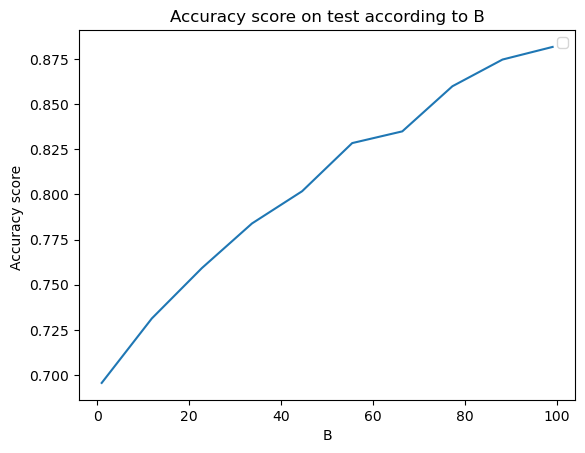

In [20]:
plt.plot(B_values, accuray_test_values)
plt.title("Accuracy score on test according to B")
plt.xlabel("B")
plt.ylabel("Accuracy score ")
plt.legend()

In [21]:
ri_train_reconstructed = model.predict(X_train)
ri_val_reconstructed = model.predict(X_val)
ri_test_reconstructed = model.predict(X_test)

accuracy_train = compute_frac(X_train.values, ri_train_reconstructed)
accuracy_val = compute_frac(X_val.values, ri_val_reconstructed)
accuracy_test = compute_frac(X_test.values, ri_test_reconstructed)

print("Fraction moyenne de signaux apprise correctement (entraînement) :", accuracy_train)
print("Fraction moyenne de signaux apprise correctement (validation) :", accuracy_val)
print("Fraction moyenne de signaux apprise correctement (test) :", accuracy_test)

13/13 [==============================] - 0s 389us/step
Fraction moyenne de signaux apprise correctement (entraînement) : 0.883871715804252
Fraction moyenne de signaux apprise correctement (validation) : 0.8979166666666667
Fraction moyenne de signaux apprise correctement (test) : 0.8815855368589743


Let's try with a deep Autoencoder

In [22]:
def build_deep_AE(N, B, loss, activation, L1_eps=0):
    inputs = Input(shape=(N,))

    encoder = Dense(256, activation=activation)(inputs)
    encoder = Dense(128, activation=activation)(encoder)
    bottleneck = Dense(B, activation=activation, bias_regularizer=keras.regularizers.L1(l1=L1_eps))(encoder)

    decoder = Dense(128, activation=activation)(bottleneck)
    decoder = Dense(256, activation=activation)(decoder)
    decoder = Dense(N, activation="linear")(decoder)

    model = keras.models.Model(inputs=inputs, outputs=decoder)

    model.compile(loss=loss, optimizer='adam')

    return inputs, encoder, bottleneck, decoder, model

In [23]:
deep_inputs, deep_encoder, deep_bottleneck, deep_decoder, deep_model = build_AE(N, B, loss, activation, L1_eps=0)

history = deep_model.fit(X_train, X_train, epochs=500, batch_size=64, validation_split=0.1, shuffle=False, callbacks=[early_stopping])

Epoch 1/500
47/47 [==============================] - 0s 3ms/step - loss: 0.0283 - val_loss: 8.4826e-04
Epoch 2/500
47/47 [==============================] - 0s 1ms/step - loss: 6.8176e-04 - val_loss: 3.7669e-04
Epoch 3/500
47/47 [==============================] - 0s 2ms/step - loss: 5.6729e-04 - val_loss: 3.5923e-04
Epoch 4/500
47/47 [==============================] - 0s 2ms/step - loss: 5.5268e-04 - val_loss: 3.4782e-04
Epoch 5/500
47/47 [==============================] - 0s 2ms/step - loss: 5.3928e-04 - val_loss: 3.3704e-04
Epoch 6/500
47/47 [==============================] - 0s 2ms/step - loss: 5.2608e-04 - val_loss: 3.2590e-04
Epoch 7/500
47/47 [==============================] - 0s 1ms/step - loss: 5.1299e-04 - val_loss: 3.1462e-04
Epoch 8/500
47/47 [==============================] - 0s 2ms/step - loss: 4.9992e-04 - val_loss: 3.0351e-04
Epoch 9/500
47/47 [==============================] - 0s 2ms/step - loss: 4.8688e-04 - val_loss: 2.9264e-04
Epoch 10/500
47/47 [=====================

Epoch 77/500
47/47 [==============================] - 0s 2ms/step - loss: 2.2098e-04 - val_loss: 1.2841e-04
Epoch 78/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1875e-04 - val_loss: 1.2754e-04
Epoch 79/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1657e-04 - val_loss: 1.2652e-04
Epoch 80/500
47/47 [==============================] - 0s 2ms/step - loss: 2.1443e-04 - val_loss: 1.2532e-04
Epoch 81/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1233e-04 - val_loss: 1.2396e-04
Epoch 82/500
47/47 [==============================] - 0s 1ms/step - loss: 2.1026e-04 - val_loss: 1.2249e-04
Epoch 83/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0821e-04 - val_loss: 1.2104e-04
Epoch 84/500
47/47 [==============================] - 0s 2ms/step - loss: 2.0619e-04 - val_loss: 1.1968e-04
Epoch 85/500
47/47 [==============================] - 0s 1ms/step - loss: 2.0421e-04 - val_loss: 1.1847e-04
Epoch 86/500
47/47 [========

47/47 [==============================] - 0s 2ms/step - loss: 1.0792e-04 - val_loss: 6.5830e-05
Epoch 153/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0699e-04 - val_loss: 6.5294e-05
Epoch 154/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0606e-04 - val_loss: 6.4777e-05
Epoch 155/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0515e-04 - val_loss: 6.4281e-05
Epoch 156/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0425e-04 - val_loss: 6.3809e-05
Epoch 157/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0336e-04 - val_loss: 6.3357e-05
Epoch 158/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0248e-04 - val_loss: 6.2921e-05
Epoch 159/500
47/47 [==============================] - 0s 2ms/step - loss: 1.0161e-04 - val_loss: 6.2494e-05
Epoch 160/500
47/47 [==============================] - 0s 1ms/step - loss: 1.0076e-04 - val_loss: 6.2066e-05
Epoch 161/500
47/47 [============

47/47 [==============================] - 0s 4ms/step - loss: 6.2292e-05 - val_loss: 4.1375e-05
Epoch 228/500
47/47 [==============================] - 0s 5ms/step - loss: 6.1897e-05 - val_loss: 4.1150e-05
Epoch 229/500
47/47 [==============================] - 0s 2ms/step - loss: 6.1504e-05 - val_loss: 4.0927e-05
Epoch 230/500
47/47 [==============================] - 0s 1ms/step - loss: 6.1113e-05 - val_loss: 4.0707e-05
Epoch 231/500
47/47 [==============================] - 0s 2ms/step - loss: 6.0725e-05 - val_loss: 4.0488e-05
Epoch 232/500
47/47 [==============================] - 0s 2ms/step - loss: 6.0340e-05 - val_loss: 4.0272e-05
Epoch 233/500
47/47 [==============================] - 0s 1ms/step - loss: 5.9960e-05 - val_loss: 4.0058e-05
Epoch 234/500
47/47 [==============================] - 0s 2ms/step - loss: 5.9584e-05 - val_loss: 3.9846e-05
Epoch 235/500
47/47 [==============================] - 0s 2ms/step - loss: 5.9212e-05 - val_loss: 3.9636e-05
Epoch 236/500
47/47 [============

47/47 [==============================] - 0s 2ms/step - loss: 4.0721e-05 - val_loss: 2.8965e-05
Epoch 303/500
47/47 [==============================] - 0s 2ms/step - loss: 4.0526e-05 - val_loss: 2.8796e-05
Epoch 304/500
47/47 [==============================] - 0s 2ms/step - loss: 4.0327e-05 - val_loss: 2.8643e-05
Epoch 305/500
47/47 [==============================] - 0s 2ms/step - loss: 4.0114e-05 - val_loss: 2.8527e-05
Epoch 306/500
47/47 [==============================] - 0s 2ms/step - loss: 3.9880e-05 - val_loss: 2.8373e-05
Epoch 307/500
47/47 [==============================] - 0s 2ms/step - loss: 3.9639e-05 - val_loss: 2.8187e-05
Epoch 308/500
47/47 [==============================] - 0s 2ms/step - loss: 3.9417e-05 - val_loss: 2.8022e-05
Epoch 309/500
47/47 [==============================] - 0s 2ms/step - loss: 3.9224e-05 - val_loss: 2.7857e-05
Epoch 310/500
47/47 [==============================] - 0s 2ms/step - loss: 3.9059e-05 - val_loss: 2.7653e-05
Epoch 311/500
47/47 [============

47/47 [==============================] - 0s 1ms/step - loss: 2.8864e-05 - val_loss: 2.0909e-05
Epoch 378/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8803e-05 - val_loss: 2.0889e-05
Epoch 379/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8736e-05 - val_loss: 2.0879e-05
Epoch 380/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8662e-05 - val_loss: 2.0879e-05
Epoch 381/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8587e-05 - val_loss: 2.0889e-05
Epoch 382/500
47/47 [==============================] - 0s 1ms/step - loss: 2.8518e-05 - val_loss: 2.0900e-05
Epoch 383/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8457e-05 - val_loss: 2.0909e-05
Epoch 384/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8411e-05 - val_loss: 2.0933e-05
Epoch 385/500
47/47 [==============================] - 0s 2ms/step - loss: 2.8396e-05 - val_loss: 2.1120e-05


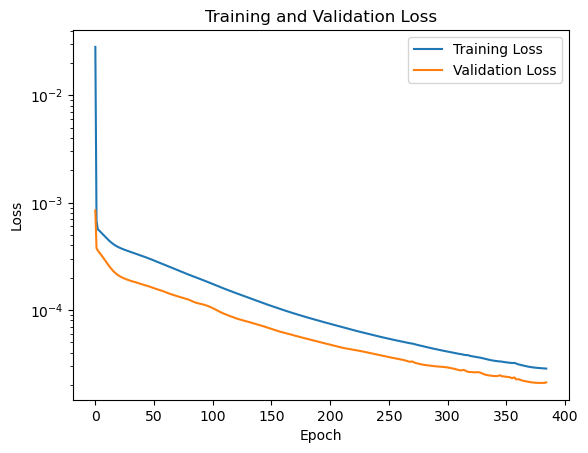

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.show()

In [25]:
deep_ri_train_reconstructed = deep_model.predict(X_train)
deep_ri_val_reconstructed = deep_model.predict(X_val)
deep_ri_test_reconstructed = deep_model.predict(X_test)

deep_accuracy_train = compute_frac(X_train.values, deep_ri_train_reconstructed)
deep_accuracy_val = compute_frac(X_val.values, deep_ri_val_reconstructed)
deep_accuracy_test = compute_frac(X_test.values, deep_ri_test_reconstructed)

print("Fraction moyenne de signaux apprise correctement (entraînement) modèle profond :", deep_accuracy_train)
print("Fraction moyenne de signaux apprise correctement (validation) modèle profond :", deep_accuracy_val)
print("Fraction moyenne de signaux apprise correctement (test) modèle profond :", deep_accuracy_test)

13/13 [==============================] - 0s 877us/step
Fraction moyenne de signaux apprise correctement (entraînement) modèle profond : 0.8778987414761332
Fraction moyenne de signaux apprise correctement (validation) modèle profond : 0.8853664658634538
Fraction moyenne de signaux apprise correctement (test) modèle profond : 0.8716696714743589


In [26]:
def build_deep_AE_tuning(hp):
    input_shape = (input_dim,)

    model = keras.Sequential()

    model.add(Dense(units=hp.Int('units_encoder1', min_value=32, max_value=512, step=32), activation=hp.Choice('activation_encoder1', values=['relu', 'sigmoid'])))
    model.add(Dense(units=hp.Int('units_encoder2', min_value=16, max_value=256, step=16), activation=hp.Choice('activation_encoder2', values=['relu', 'sigmoid'])))

    bottleneck = Dense(units=hp.Int('units_bootlneck1', min_value=10, max_value=100, step=5), activation=hp.Choice('activation_encoder1', values=['relu', 'sigmoid']))

    model.add(Dense(units=hp.Int('units_decoder1', min_value=16, max_value=256, step=16), activation=hp.Choice('activation_decoder1', values=['relu', 'sigmoid'])))
    model.add(Dense(units=hp.Int('units_decoder2', min_value=32, max_value=512, step=32), activation=hp.Choice('activation_decoder2', values=['relu', 'sigmoid'])))
    model.add(Dense(units=input_dim, activation='sigmoid'))

    model.compile(optimizer='adam', loss=hp.Choice('loss', values=['mse', 'mae']))

    return model

input_dim = N

tuner = RandomSearch(
    build_deep_AE_tuning,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_tuning_directory',
    project_name='autoencoder_tuning')

tuner.search(X_train, X_train, epochs=500, validation_data=(X_val, X_val), callbacks=[early_stopping])

Trial 5 Complete [00h 00m 15s]
val_loss: 0.013024340694149336

Best val_loss So Far: 0.00037986870544652146
Total elapsed time: 00h 03m 10s


In [27]:
best_hps = tuner.get_best_hyperparameters(num_trials=4)[0]
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(X_train, X_train, epochs=50, validation_data=(X_val, X_val), callbacks=[early_stopping])

Epoch 1/50
104/104 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.0096
Epoch 2/50
104/104 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 3/50
104/104 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 4/50
104/104 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/50
104/104 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 6/50
104/104 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.5700e-04
Epoch 7/50
104/104 [==============================] - 0s 2ms/step - loss: 9.9756e-04 - val_loss: 7.4606e-04
Epoch 8/50
104/104 [==============================] - 0s 2ms/step - loss: 9.0560e-04 - val_loss: 6.7079e-04
Epoch 9/50
104/104 [==============================] - 0s 2ms/step - loss: 8.4167e-04 - val_loss: 6.1743e-04
Epoch 10/50
104/104 [==============================] - 0s 2ms/step - los

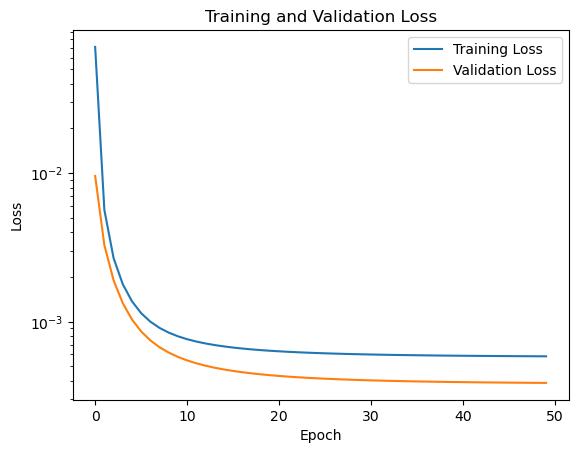

In [28]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.show()

In [29]:
best_ri_train_reconstructed = best_model.predict(X_train)
best_ri_val_reconstructed = best_model.predict(X_val)
best_ri_test_reconstructed = best_model.predict(X_test)

best_accuracy_train = compute_frac(X_train.values, best_ri_train_reconstructed)
best_accuracy_val = compute_frac(X_val.values, best_ri_val_reconstructed)
best_accuracy_test = compute_frac(X_test.values, best_ri_test_reconstructed)

print("Fraction moyenne de signaux apprise correctement (entraînement) modèle profond tuné :", best_accuracy_train)
print("Fraction moyenne de signaux apprise correctement (validation) modèle profond tuné :", best_accuracy_val)
print("Fraction moyenne de signaux apprise correctement (test) modèle profond tuné :", best_accuracy_test)

13/13 [==============================] - 0s 815us/step
Fraction moyenne de signaux apprise correctement (entraînement) modèle profond tuné : 0.48940784195748094
Fraction moyenne de signaux apprise correctement (validation) modèle profond tuné : 0.5110692771084338
Fraction moyenne de signaux apprise correctement (test) modèle profond tuné : 0.5214593349358975


Il faudrait une très grande capacité de calcul pour faire un grid search (ou random search) pour trouver les meilleurs paramètres de notre modèle. Ici cela était simplement pour illustrer l'importance du choix de l'architecture.

13/13 [==============================] - 0s 657us/step


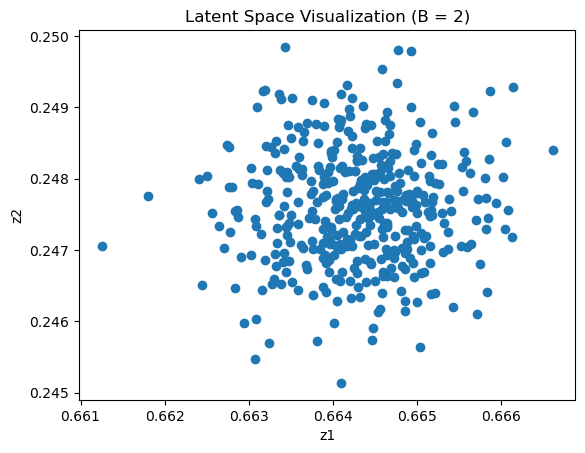

In [30]:
def build_AE_latent(N, B, loss, activation, L1_eps=0):
    inputs = Input(shape=(N,))
    encoder = Dense(N, activation=activation)(inputs)
    bottleneck = Dense(B, activation=activation, bias_regularizer=keras.regularizers.L1(l1=L1_eps))(encoder)
    decoder = Dense(N, activation="linear")(bottleneck)

    model = Model(inputs=inputs, outputs=decoder)
    model.compile(loss=loss, optimizer='adam')

    encoder_model = Model(inputs=inputs, outputs=bottleneck)

    return inputs, encoder, bottleneck, decoder, model, encoder_model

B = 2

inputs, encoder, bottleneck, decoder, model, encoder_model = build_AE_latent(N, B, loss, activation, L1_eps=0)

encoded_states = encoder_model.predict(X_test)


plt.scatter(encoded_states[:, 0], encoded_states[:, 1])
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Latent Space Visualization (B = 2)')
plt.show()


13/13 [==============================] - 0s 2ms/step


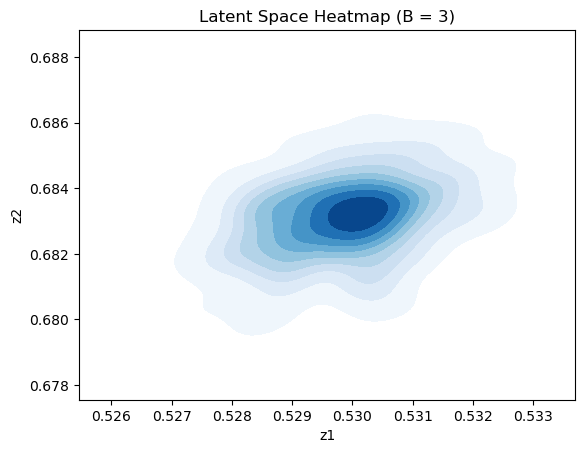

In [31]:
B = 3
inputs, encoder, bottleneck, decoder, model, encoder_model = build_AE_latent(N, B, loss, activation, L1_eps=0)

encoded_states = encoder_model.predict(X_test)

sns.kdeplot(x=encoded_states[:, 0], y=encoded_states[:, 1], fill=True, cmap="Blues", thresh=0.05)
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Latent Space Heatmap (B = 3)')
plt.show()

13/13 [==============================] - 0s 1ms/step


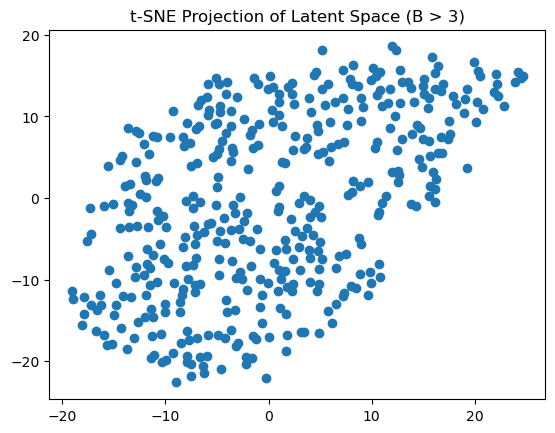

In [32]:
B = 5

inputs, encoder, bottleneck, decoder, model, encoder_model = build_AE_latent(N, B, loss, activation, L1_eps=0)
encoded_states = encoder_model.predict(X_test)

tsne_model = TSNE(n_components=2, random_state=42)

tsne_latents = tsne_model.fit_transform(encoded_states)

plt.scatter(tsne_latents[:, 0], tsne_latents[:, 1])
plt.title('t-SNE Projection of Latent Space (B > 3)')
plt.show()

In [33]:
"""

B = 5

inputs, encoder, bottleneck, decoder, model, encoder_model = build_AE_latent(N, B, loss, activation, L1_eps=0)

encoded_states = encoder_model.predict(X_test)

umap_model = umap.UMAP(n_components=2)
umap_latents = umap_model.fit_transform(encoded_states)

plt.scatter(umap_latents[:, 0], umap_latents[:, 1], cmap="viridis", s=10)
plt.colorbar()
plt.title('UMAP Projection of Latent Space (B > 3)')
plt.show()
"""

'\n\nB = 5\n\ninputs, encoder, bottleneck, decoder, model, encoder_model = build_AE_latent(N, B, loss, activation, L1_eps=0)\n\nencoded_states = encoder_model.predict(X_test)\n\numap_model = umap.UMAP(n_components=2)\numap_latents = umap_model.fit_transform(encoded_states)\n\nplt.scatter(umap_latents[:, 0], umap_latents[:, 1], cmap="viridis", s=10)\nplt.colorbar()\nplt.title(\'UMAP Projection of Latent Space (B > 3)\')\nplt.show()\n'

Pour la prédiction, nous pouvons utiliser des AE de différentes manières. Par exemple, nous pouvons entraîner un AE et récupérer le bottleneck qu'on mettrait en entrée d'un modèle de prédiction. De plus, un AE peut être utiliser pour générer des séries chronologiques ayant les mêmes caractéristiques que la série étudiée. Ainsi, cela permet donc d'élargir le dataset de train et donc agmenter la robustesse du modèle de prédiction.

# 2. Etats de marché

In [34]:
X_train_transposed = X_train.T  # Now each column is a day, and each row represents all assets for that day.
X_test_transposed = X_test.T
X_val_transposed = X_val.T
print(X_train_transposed)

           0         1         2         3         4         5         6     \
^GSPC -0.007032  0.012328 -0.004491  0.027738 -0.002796  0.004539  0.003393   
GE    -0.014556  0.018882  0.002156  0.032489  0.016541  0.006133  0.000679   
IBM    0.010490 -0.002737 -0.015313  0.034315  0.000000 -0.008839  0.005165   
DIS   -0.026062  0.018079  0.000943  0.023739 -0.002303  0.005517  0.007764   
BA    -0.022809  0.023845 -0.028630  0.015598  0.018969 -0.002319 -0.014030   
...         ...       ...       ...       ...       ...       ...       ...   
GPS   -0.011327  0.033603 -0.007106  0.028127 -0.004633 -0.002325 -0.015638   
ACG   -0.004211  0.008403  0.000000  0.008333  0.012371 -0.008230  0.000000   
GTY   -0.003906 -0.005888 -0.007905  0.017700 -0.007828  0.003922  0.000000   
LEO   -0.005634  0.005634  0.000000  0.008392 -0.008392  0.000000  0.008392   
VGR    0.046520 -0.022990  0.022990  0.022473  0.032790  0.052368 -0.041673   

           7         8         9     ...      3314 

In [35]:
N = len(X_train_transposed.columns)
B = 30
loss = 'mse'
activation = 'sigmoid'

inputs, encoder, bottleneck, decoder, model = build_AE(N, B, loss, activation, L1_eps=0.01)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_transposed, X_train_transposed, epochs=500, batch_size=64, validation_split=0.1, shuffle=False, callbacks=[early_stopping])

Epoch 1/500
2/2 [==============================] - 0s 101ms/step - loss: 0.0042 - val_loss: 6.4118e-04
Epoch 2/500
2/2 [==============================] - 0s 41ms/step - loss: 6.8275e-04 - val_loss: 7.9490e-04
Epoch 3/500
2/2 [==============================] - 0s 40ms/step - loss: 8.0233e-04 - val_loss: 6.6579e-04
Epoch 4/500
2/2 [==============================] - 0s 58ms/step - loss: 6.4610e-04 - val_loss: 6.0092e-04
Epoch 5/500
2/2 [==============================] - 0s 39ms/step - loss: 6.0976e-04 - val_loss: 5.5094e-04
Epoch 6/500
2/2 [==============================] - 0s 53ms/step - loss: 5.6762e-04 - val_loss: 6.1686e-04
Epoch 7/500
2/2 [==============================] - 0s 41ms/step - loss: 6.1304e-04 - val_loss: 5.4560e-04
Epoch 8/500
2/2 [==============================] - 0s 33ms/step - loss: 5.3962e-04 - val_loss: 5.5746e-04
Epoch 9/500
2/2 [==============================] - 0s 57ms/step - loss: 5.4982e-04 - val_loss: 5.0716e-04
Epoch 10/500
2/2 [==============================]

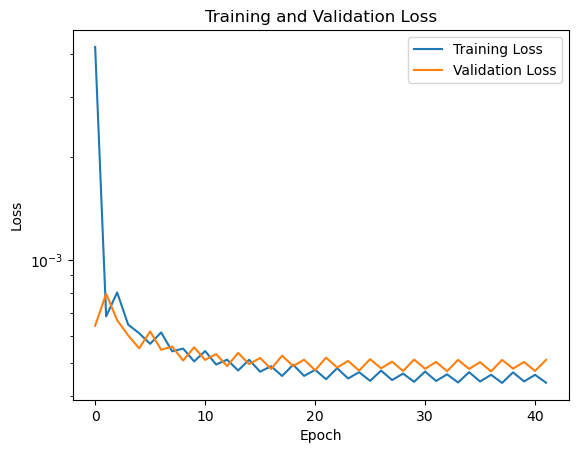

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.show()

In [37]:
def compute_frac_vec(ri_original, ri_reconstructed):
    vals = np.where(np.sign(ri_original) == np.sign(ri_reconstructed), 1, 0)
    return np.sum(vals)/(np.shape(X_train_transposed)[0] * np.shape(X_train_transposed)[1])

In [38]:
X_train_transposed_reconstructed = model.predict(X_train_transposed)

accuracy_train = compute_frac_vec(X_train_transposed.values, X_train_transposed_reconstructed)

print("Fraction moyenne de signaux apprise correctement (train) :", accuracy_train)

3/3 [==============================] - 0s 8ms/step
Fraction moyenne de signaux apprise correctement (train) : 0.6668954322101885


# 3. Détection d'anomalies

In [39]:
X_train

,^GSPC,GE,IBM,DIS,BA,CAT,AA,DD,XOM,PG,...,TER,BHP,DCI,WGL,SYY,GPS,ACG,GTY,LEO,VGR
0,-0.007032,-0.014556,0.010490,-0.026062,-0.022809,0.003367,-0.014736,-0.006903,-0.013084,0.015741,...,-0.005908,-0.014815,0.004193,0.007423,0.013423,-0.011327,-0.004211,-0.003906,-0.005634,0.046520
1,0.012328,0.018882,-0.002737,0.018079,0.023845,0.007257,-0.018387,0.003043,0.014940,0.015058,...,0.020891,-0.018411,0.012474,0.009812,0.029559,0.033603,0.008403,-0.005888,0.005634,-0.022990
2,-0.004491,0.002156,-0.015313,0.000943,-0.028630,-0.009500,0.019061,-0.013068,-0.004645,0.013968,...,-0.078050,0.000000,0.000000,-0.007350,0.006452,-0.007106,0.000000,-0.007905,0.000000,0.022990
3,0.027738,0.032489,0.034315,0.023739,0.015598,0.040170,0.027927,0.003911,0.029360,0.053999,...,0.066375,-0.001691,-0.004141,0.017067,0.014366,0.028127,0.008333,0.017700,0.008392,0.022473
4,-0.002796,0.016541,0.000000,-0.002303,0.018969,-0.007037,-0.015197,0.022875,0.000000,0.000821,...,-0.046957,-0.017065,0.006205,-0.024471,-0.020817,-0.004633,0.012371,-0.007828,-0.008392,0.032790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3319,0.015241,0.014115,0.016807,0.009605,0.033190,0.023688,0.033152,0.019067,0.018552,0.011847,...,0.033133,0.025825,0.060310,-0.043034,0.011278,0.010241,0.006473,0.010920,-0.014140,0.011669
3320,0.002537,0.011150,0.004834,-0.015298,-0.015949,0.010293,0.000000,0.012118,0.003392,0.000346,...,0.017007,-0.008706,0.001936,-0.007098,-0.005428,-0.009726,0.012821,0.000402,0.028083,-0.006985
3321,-0.001577,-0.011851,0.002335,-0.001714,0.006915,0.000384,-0.007012,-0.006397,-0.005093,-0.007647,...,0.054954,0.001157,0.004631,0.013535,0.006588,-0.005675,-0.009600,0.016747,0.022815,0.001556
3322,-0.014387,-0.016974,-0.015353,-0.022557,-0.006745,-0.016514,-0.011797,-0.016296,-0.017324,-0.014940,...,0.000000,-0.038758,-0.013569,-0.005822,0.001158,0.000000,0.001606,-0.008338,-0.013626,-0.003896


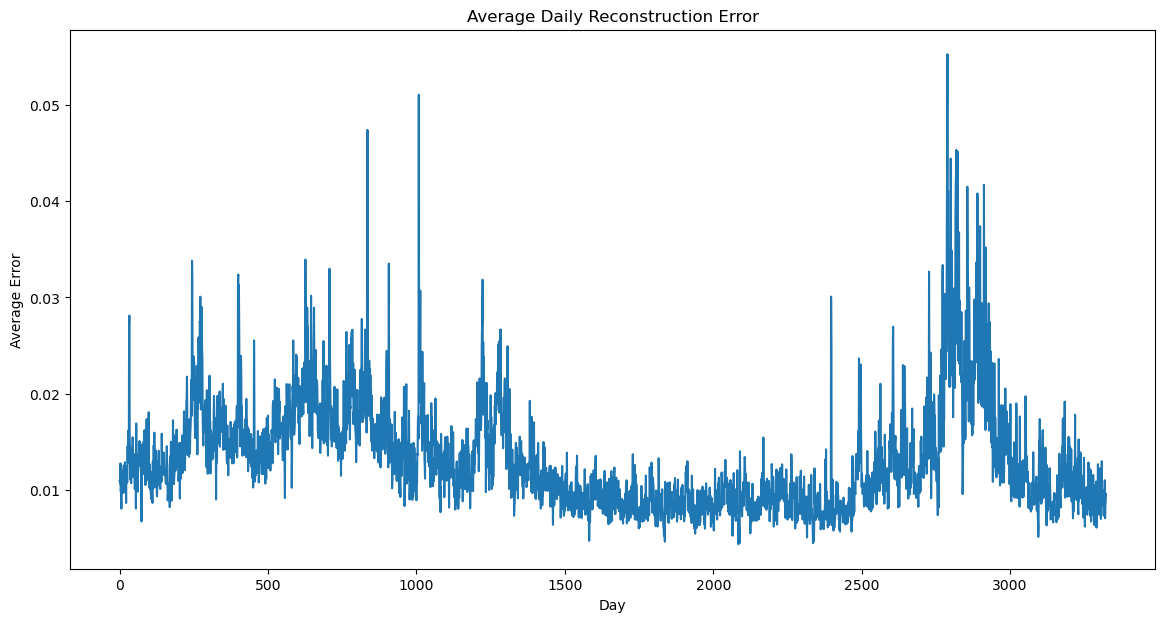

In [40]:
reconstruction_error = (X_train_transposed.T - X_train_transposed_reconstructed.T).abs()

daily_error_mean = reconstruction_error.mean(axis=1)
plt.figure(figsize=(14, 7))
daily_error_mean.plot(title='Average Daily Reconstruction Error')
plt.xlabel('Day')
plt.ylabel('Average Error')
plt.show()

In [41]:
window_size = 30

rolling_std_per_series = X_train.rolling(window=window_size).std()

mean_std_across_series = rolling_std_per_series.mean(axis=1)

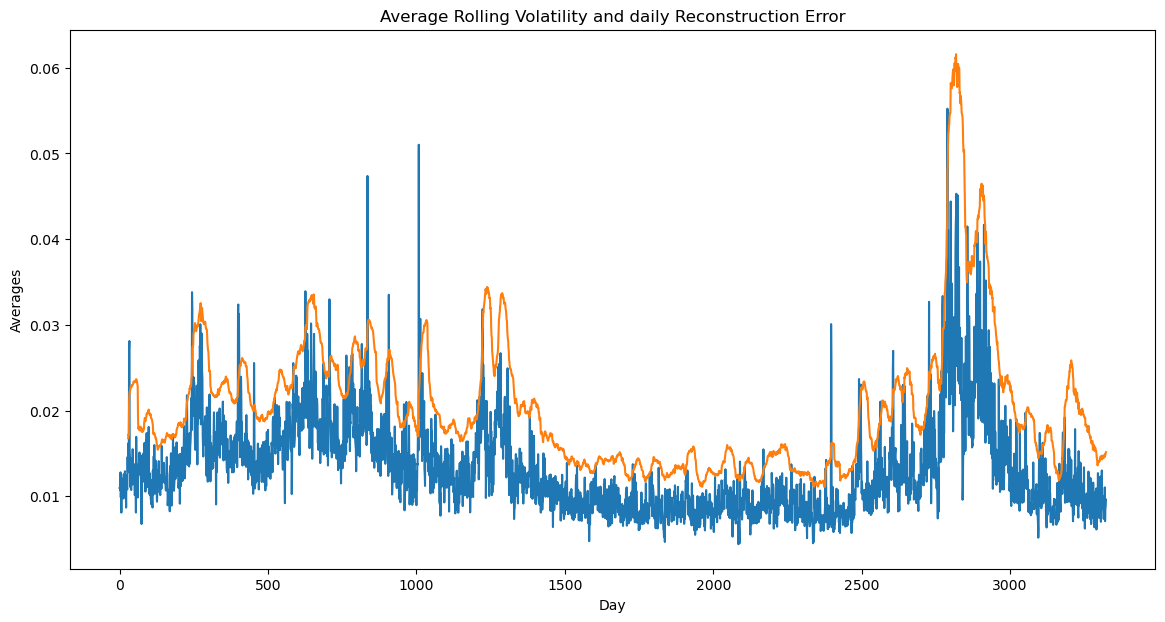

In [42]:
plt.figure(figsize=(14, 7))
daily_error_mean.plot()
mean_std_across_series.plot(title='Average Rolling Volatility and daily Reconstruction Error')
plt.xlabel('Day')
plt.ylabel('Averages')
plt.show()

Nous remarquons que lors de période de fortes volatilités, l'erreur de reconstruction moyenne est plus importante.

In [43]:
asset_error_mean = reconstruction_error.mean(axis=0)
sorted_assets = asset_error_mean.sort_values(ascending=False)
print(sorted_assets)

AMD      0.027302
TER      0.025064
FRM      0.022415
VHI      0.019862
GCO      0.019603
           ...   
IDA      0.009207
WGL      0.009055
ED       0.008962
MMM      0.008955
^GSPC    0.003457
Length: 96, dtype: float64


In [44]:
rolling_std_per_series = X_train.rolling(window=window_size).std()

mean_std_foreache_serie = rolling_std_per_series.mean(axis=0)

In [45]:
mean_std_foreache_serie.sort_values(ascending=False)

AMD      0.040527
TER      0.037287
FRM      0.032525
GCO      0.030857
VHI      0.030743
           ...   
^GSPC    0.011936
ED       0.011664
DNP      0.010304
LEO      0.008900
ACG      0.008555
Length: 96, dtype: float64

Nous remarquons également ici que les tickers ayant eu l'erreur moyenne de reconsrtuction la plus élevée sont les tickers dont la volaitlité est la plus importante. A L'inverse, les tickers avec une volatilité très faible sont très bien reconstruits. Cela peut être expliqué par le fait que la volaitlité traduit une incertitude et donc une présence importante de bruit.